# Data Exploration

**Reminder**
- Independent variable = X = informal institutions = nbrsnci_dv = Higher values represent greater cohesion, ranging from 1 “lowest cohesion” to 5 “highest cohesion”.
- Dependent variable = Y = subjective wellbeing = scghq1_dv = Range of scores from 0 (indicating the least amount of distress) to 36 (indicating the greatest amount of distress)

In [1]:
import pandas as pd                                 
from pathlib import Path                           
import matplotlib.pyplot as plt                     
import seaborn as sns                              
import numpy as np                                  
from scipy.stats import norm                        
from sklearn.preprocessing import StandardScaler    
from scipy import stats                             
import statsmodels.api as sm                       
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)  # Show all columns when displaying a dataframe
import pyreadstat
from IPython.display import display
from IPython import get_ipython

def enable_df_scroll(height=360):
    ip = get_ipython()
    html_fmt = ip.display_formatter.formatters['text/html']

    def _df_html(df):
        return f"<div style='max-height:{height}px; overflow:auto; border:1px solid #aaa'>{df.to_html()}</div>"

    def _ser_html(s):
        return f"<div style='max-height:{height}px; overflow:auto; border:1px solid #aaa'>{s.to_frame().to_html()}</div>"

    html_fmt.for_type(pd.DataFrame, _df_html)
    html_fmt.for_type(pd.Series,   _ser_html)

enable_df_scroll(height=300)   # call once; change height if you like

In [2]:
# Import file

path = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/refinedvariables.dta"
df, meta = pyreadstat.read_dta(path)

print("Shape:", df.shape)
df.head()

Shape: (175335, 18)


,pidp,wave,wave_num,hidp,nbrsnci_dv,gor_dv,urban_dv,sex_dv,age_dv,ethn_dv,marstat_dv,jbstat,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,scghq1_dv,hiqual_dv
0,22445,f,6,278664010,3.4,7,1,2,29,1,6,2,2012.000000,NaN,NaN,2,25,3
1,22445,i,9,277344816,3.3,7,1,2,33,1,1,2,1289.699951,1289.699951,1300.0,2,11,3
2,22445,l,12,276637622,1.6,7,1,2,35,1,1,6,145.169998,4146.390137,1350.0,2,32,1
3,29925,f,6,620547610,4.1,7,1,2,37,1,5,1,2175.620117,2175.620117,1451.0,1,11,1
4,29925,i,9,619024416,3.5,7,1,2,40,1,4,2,2904.530029,2904.530029,0.0,1,9,1


In [3]:
# Create a table showing the number of observations in each wave

wave_table = df['wave'].value_counts().sort_index()

display(wave_table)

,count
wave,
a,37988
c,40509
f,35472
i,33137
l,28229


## Transforming the explanatory variables

1. Drop all rows with missing values
2. Drop all rows with negative values (i.e. those that indicate "not applicable" or "don't know")
3. Define variables as categorical or continuous, and adjust values accordingly
    - One-hot encode categorical variables
    - Transform binary variables to 0/1
    - Scale continuous variables (standardize to mean 0, sd 1)

Lets start off by identifying which variables are causing the most unusable values

In [4]:
# Calculate % missing and % negative for each column
missing_pct = df.isnull().mean() 
negative_pct = (df.select_dtypes(include=['number']) < 0).mean() * 100   #'number' includes int, float, etc.

# Combine into a summary DataFrame and sort by the sum of % missing and % negative (descending)
summary = pd.DataFrame({
    '% Missing': missing_pct,
    '% Negative': negative_pct
}).fillna(0) # Fill NaN values with 0 for non-numeric columns

summary['% Total'] = summary['% Missing'] + summary['% Negative']
summary = summary.sort_values(by='% Total', ascending=False)

summary.head(10)

,% Missing,% Negative,% Total
hiqual_dv,0.000000,0.666153,0.666153
marstat_dv,0.000000,0.220150,0.220150
health,0.000000,0.100950,0.100950
fimnnet_dv,0.000000,0.074714,0.074714
ethn_dv,0.000000,0.045057,0.045057
houscost1_dv,0.010511,0.032509,0.043021
fihhmnnet1_dv,0.010511,0.031369,0.041880
jbstat,0.000000,0.024524,0.024524
gor_dv,0.000000,0.022813,0.022813
urban_dv,0.000000,0.022813,0.022813


This is helpful! It doesn't look like any variables are particularly problematic, so I'll just drop rows with any missing or negative values.

In [5]:
# Record shape before dropping rows with missing or negative values
initial_shape = df.shape

# Drop rows with any missing or negative values
df = df.dropna()
df = df[(df.select_dtypes(include=['number']) >= 0).all(axis=1)]

print("Shape after dropping rows with missing or negative values:", df.shape)
print("Number of rows dropped:", initial_shape[0] - df.shape[0])

Shape after dropping rows with missing or negative values: (171525, 18)
Number of rows dropped: 3810


Perfect! Only 3810 rows dropped. 

Now, lets define the explanatory variables as numeric or nominal, and adjust values accordingly.

In [6]:
# Define explanatory variables, X, excluding all identifier variables and the dependent variable

df = df.drop(columns=['pidp', 'wave', 'wave_num', 'hidp'])

# Define Y
Y_processed = df['scghq1_dv']

# Define X
X = df.drop(columns=['scghq1_dv'])

# 1. Numeric: nbrsnci_dv, age_dv, fimnnet_dv, fihhmnnet1_dv, houscost1_dv (to be scaled in next step)

# 2. Nominal categorical: gor_dv, ethn_dv, marstat_dv, jbstat, hiqual_dv (one-hot encode and make binary)
X_processed = pd.get_dummies(
    X,
    columns= ['gor_dv', 'ethn_dv', 'marstat_dv', 'jbstat', 'hiqual_dv'],
    drop_first=True)

# Convert all boolean columns to int (0/1)
bool_cols = X_processed.select_dtypes(include='bool').columns
X_processed[bool_cols] = X_processed[bool_cols].astype(int)

# 3. Binary: urban_dv, sex_dv, health (convert to 0/1)
# Assume current encoding is not 0/1, so map the lowest value to 0, highest to 1
X_processed['urban_dv'] = (X_processed['urban_dv'] == X_processed['urban_dv'].max()).astype(int)
X_processed['sex_dv'] = (X_processed['sex_dv'] == X_processed['sex_dv'].max()).astype(int)
X_processed['health'] = (X_processed['health'] == X_processed['health'].max()).astype(int)

# Show the processed DataFrame info
display(X_processed.head())

print(f"X_processed Shape: {X_processed.shape}")

,nbrsnci_dv,urban_dv,sex_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,gor_dv_2,gor_dv_3,gor_dv_4,gor_dv_5,gor_dv_6,gor_dv_7,gor_dv_8,gor_dv_9,gor_dv_10,gor_dv_11,gor_dv_12,ethn_dv_2,ethn_dv_4,ethn_dv_5,ethn_dv_6,ethn_dv_7,ethn_dv_8,ethn_dv_9,ethn_dv_10,ethn_dv_11,ethn_dv_12,ethn_dv_13,ethn_dv_14,ethn_dv_15,ethn_dv_16,ethn_dv_17,ethn_dv_97,marstat_dv_1,marstat_dv_2,marstat_dv_3,marstat_dv_4,marstat_dv_5,marstat_dv_6,jbstat_2,jbstat_3,jbstat_4,jbstat_5,jbstat_6,jbstat_7,jbstat_8,jbstat_9,jbstat_10,jbstat_11,jbstat_12,jbstat_13,jbstat_97,hiqual_dv_2,hiqual_dv_3,hiqual_dv_4,hiqual_dv_5,hiqual_dv_9
1,3.3,0,1,33,1289.699951,1289.699951,1300.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1.6,0,1,35,145.169998,4146.390137,1350.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.1,0,1,37,2175.620117,2175.620117,1451.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.5,0,1,40,2904.530029,2904.530029,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3.8,0,1,43,2985.340088,2985.340088,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


X_processed Shape: (171525, 59)


In [7]:
# Scale continuous predictors in X_processed

from sklearn.preprocessing import StandardScaler

continuous_cols = X_processed[['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']].columns

scaler = StandardScaler()

X_processed[continuous_cols] = scaler.fit_transform(X_processed[continuous_cols])

print('\nX_processed shape after scaling:', X_processed.shape)
display(X_processed[continuous_cols].head())



X_processed shape after scaling: (171525, 59)


,nbrsnci_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv
1,-0.367783,-0.822642,-0.079941,-0.300213,0.627616
2,-2.688030,-0.713412,-0.537674,0.124887,0.662878
3,0.724098,-0.604181,0.274366,-0.168380,0.734107
4,-0.094813,-0.440336,0.565880,-0.059912,-0.289201
5,0.314643,-0.276491,0.598198,-0.047887,-0.289201


## Visualising the data

### Univariate analysis

Subjective wellbeing (scghq1_dv) 

count    171525.000000
mean         11.180539
std           5.518984
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max          36.000000
Name: scghq1_dv, dtype: float64


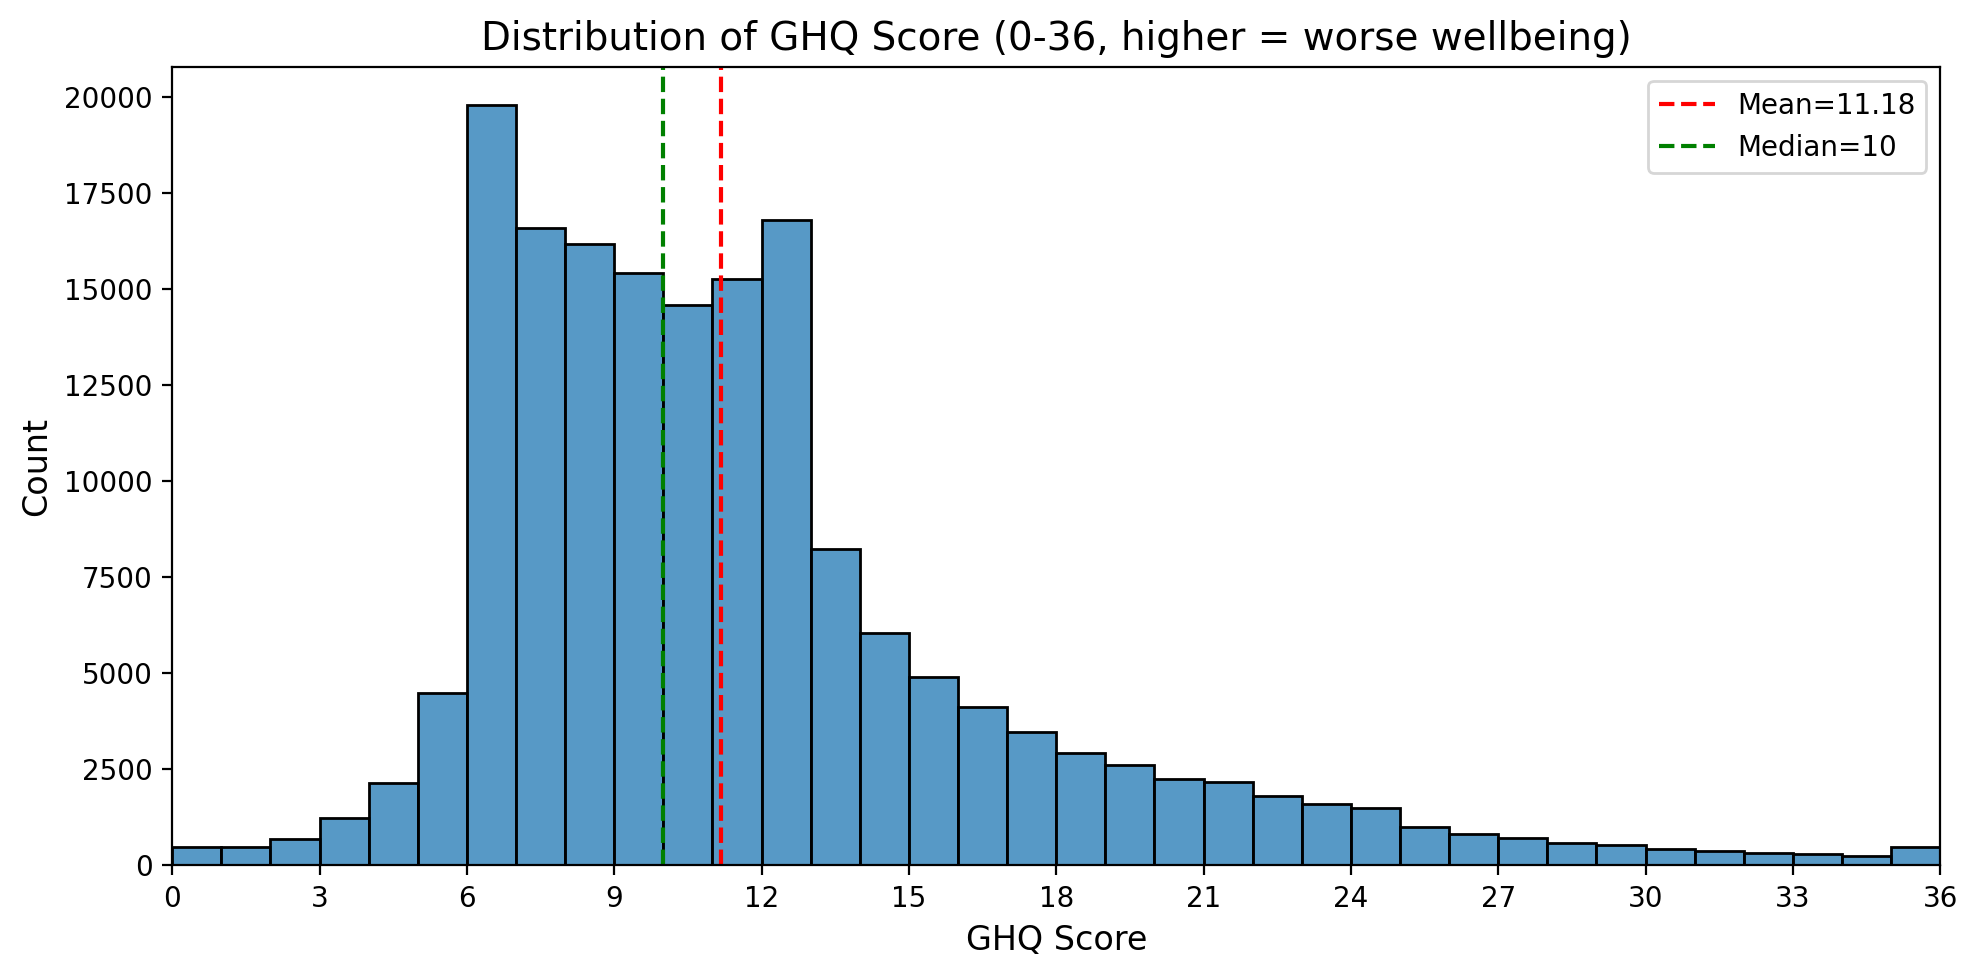

In [8]:
# Histogram of Y_processed (GHQ score)

# Print Y_processed descriptive statistics
print(Y_processed.describe())

# Create bins from 0 to 36 (the full range of GHQ scores)
bins = np.arange(0, 37)

plt.figure(figsize=(10, 5))
sns.histplot(Y_processed, bins=bins, kde=False, color='C0')

# Add mean and median lines
plt.axvline(Y_processed.mean(), color="red", linestyle="--", label=f"Mean={Y_processed.mean():.2f}")
plt.axvline(Y_processed.median(), color="green", linestyle="--", label=f"Median={Y_processed.median():.0f}")

# Add labels and title
plt.title('Distribution of GHQ Score (0-36, higher = worse wellbeing)', fontsize=14)
plt.xlabel('GHQ Score', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-axis to show full range
plt.xlim(0, 36)
plt.xticks(np.arange(0, 37, 3))  # Show ticks every 3 points

plt.legend()
plt.tight_layout()
plt.show()

Age distribution

count    171525.000000
mean         48.062527
std          18.309999
min          15.000000
25%          33.000000
50%          48.000000
75%          62.000000
max         102.000000
Name: age_dv, dtype: float64


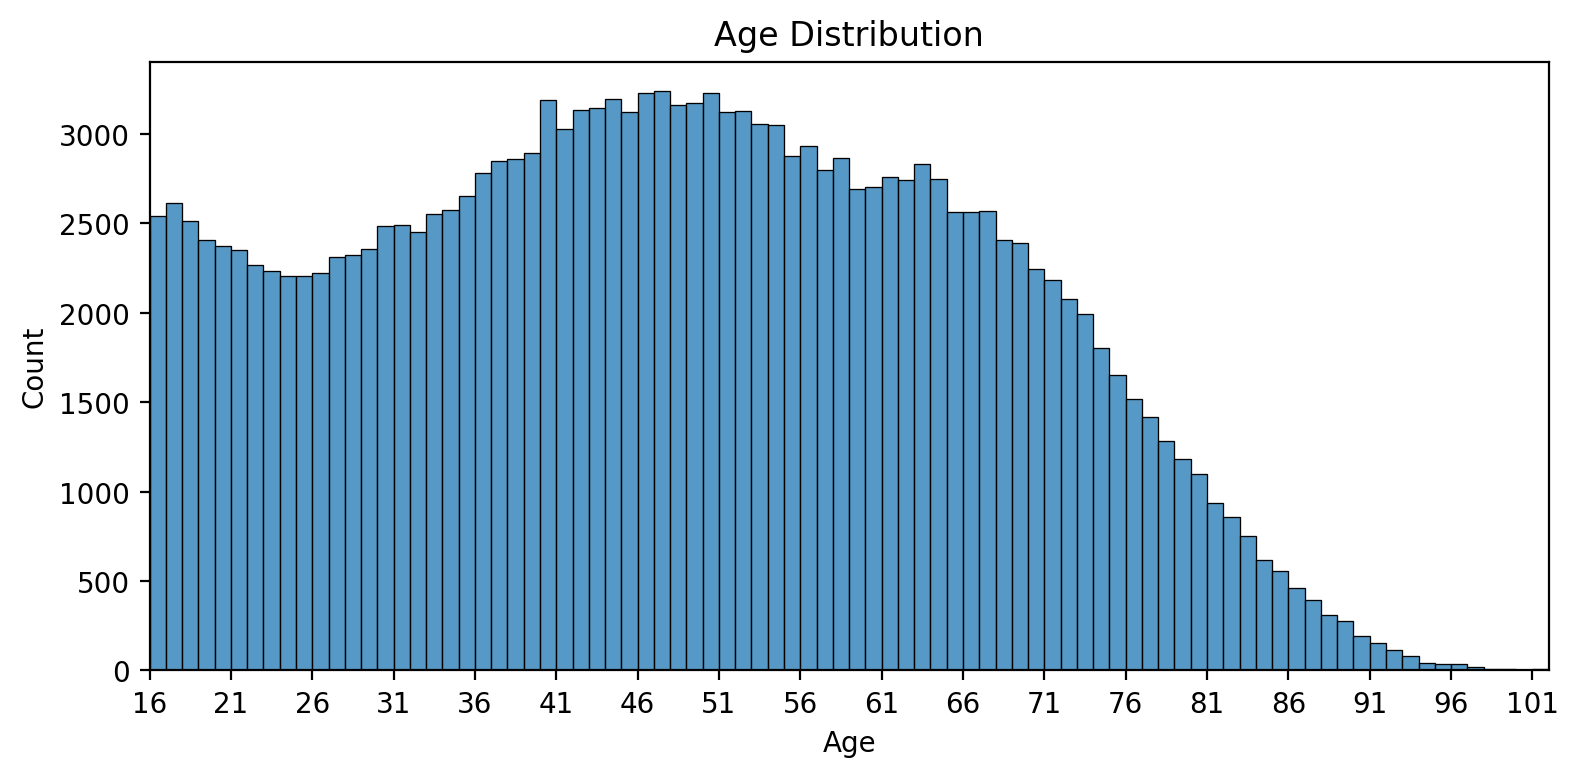

In [9]:

col = 'age_dv'
age_min = X[col].min() + 1
age_max = X[col].max()

# Print descriptive statistics
print(X[col].describe())

# bins of width 1, starting from the min value
bins = np.arange(age_min, age_max + 1, 1)

plt.figure(figsize=(8, 4))
sns.histplot(X[col], bins=bins, kde=False, color='C0')

# Set x-axis to show full range
plt.xlim(age_min, age_max)
plt.xticks(np.arange(age_min, age_max + 1, 5))  # Show ticks every 5 points

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Income

Income min: 0.0, max: 387060.71875


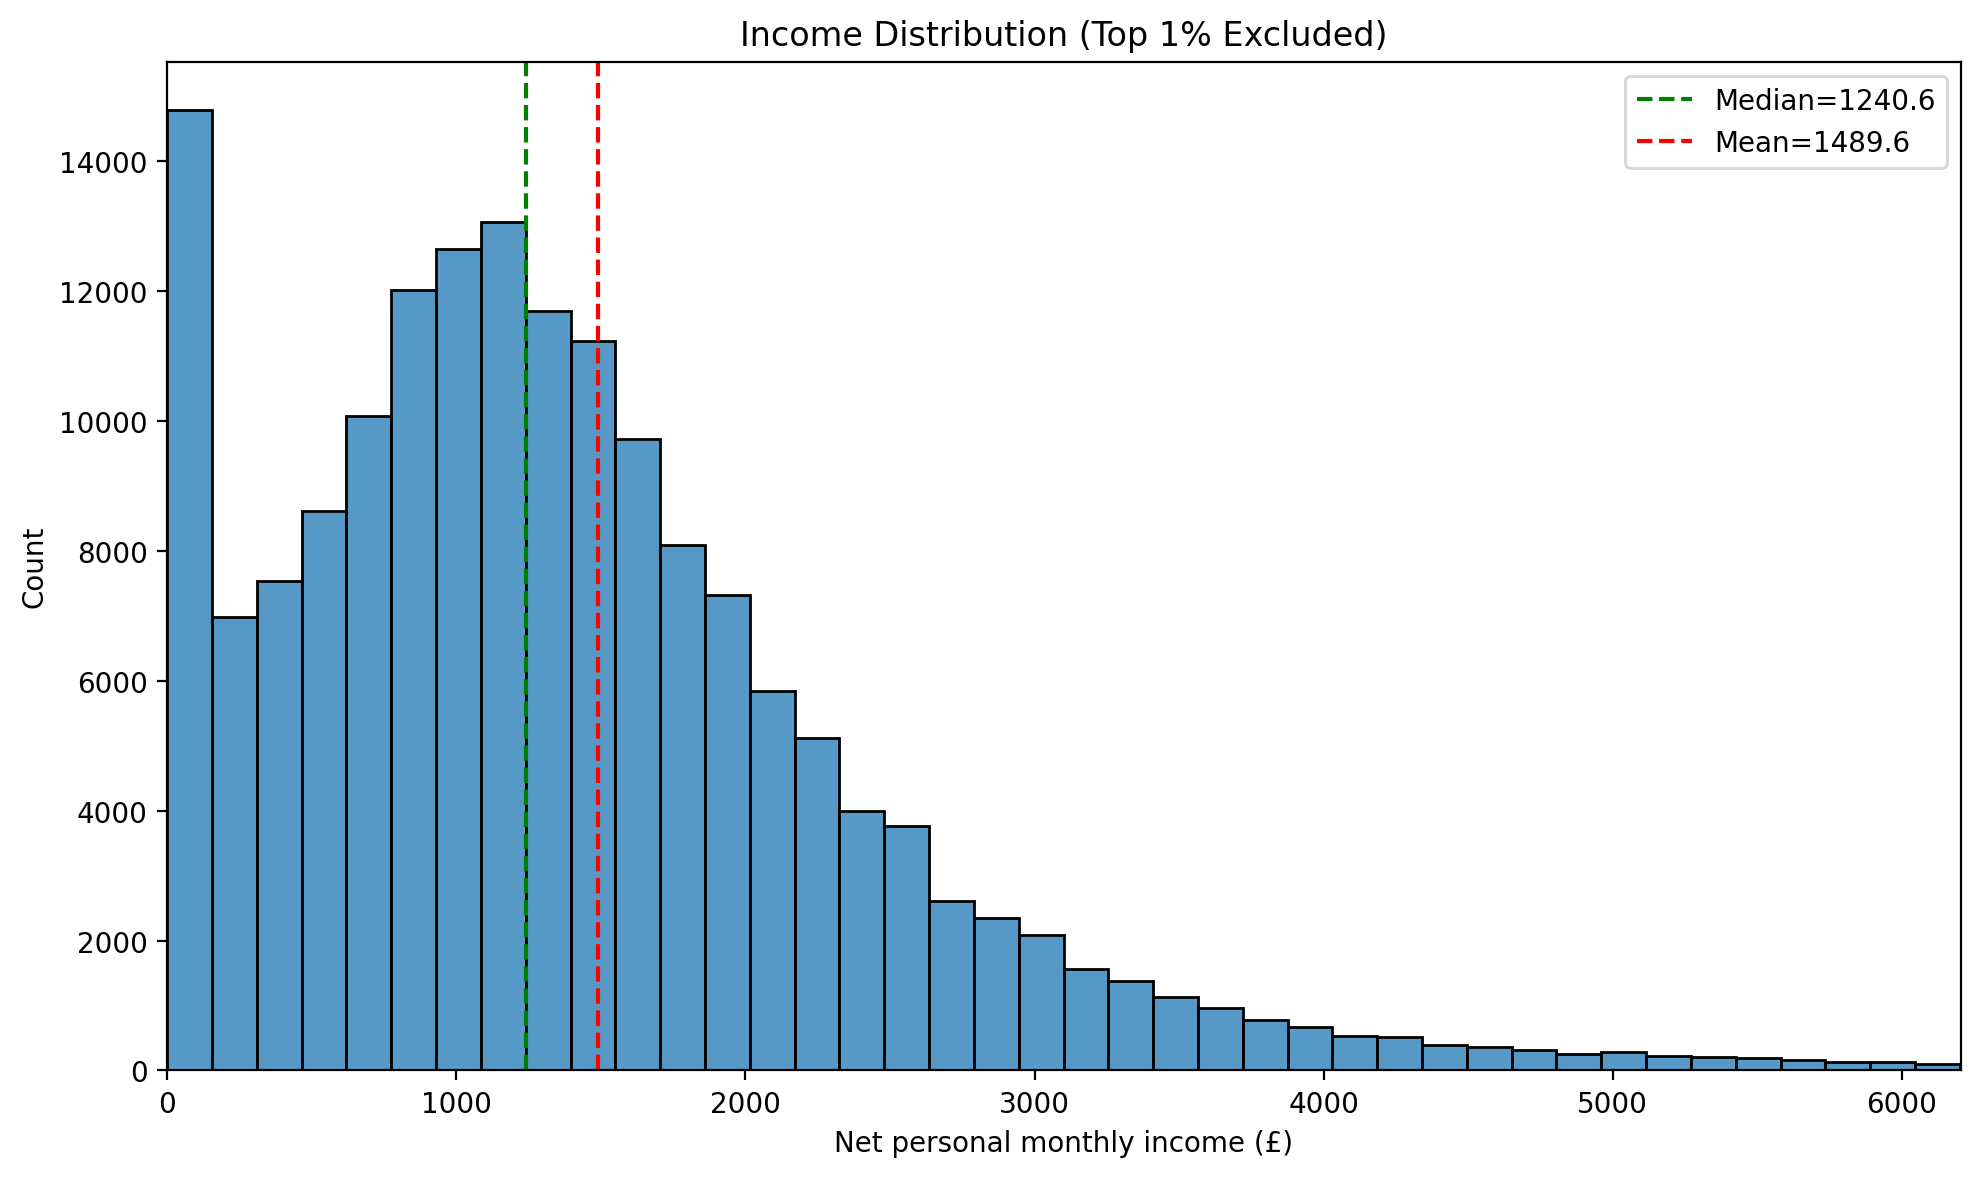

In [10]:
col = 'fimnnet_dv'
income_min = X[col].min()
income_max = X[col].max()

print(f"Income min: {income_min}, max: {income_max}")

plt.figure(figsize=(10, 6))
# Limit the x-axis to focus on the majority of the data (e.g., incomes below the 99th percentile)
upper_limit = np.percentile(X[col], 99)
sns.histplot(X[col][X[col] <= upper_limit], bins=40, kde=False, color='C0')
plt.xlim(X[col].min(), upper_limit)
plt.title('Income Distribution (Top 1% Excluded)')
plt.xlabel('Net personal monthly income (£)')
plt.ylabel('Count')
plt.axvline(X[col].median(), color="green", linestyle="--", label=f"Median={X[col].median():.1f}")
plt.axvline(X[col].mean(), color="red", linestyle="--", label=f"Mean={X[col].mean():.1f}")
plt.legend()
plt.tight_layout()
plt.show()


Social cohesion (informal institutions)

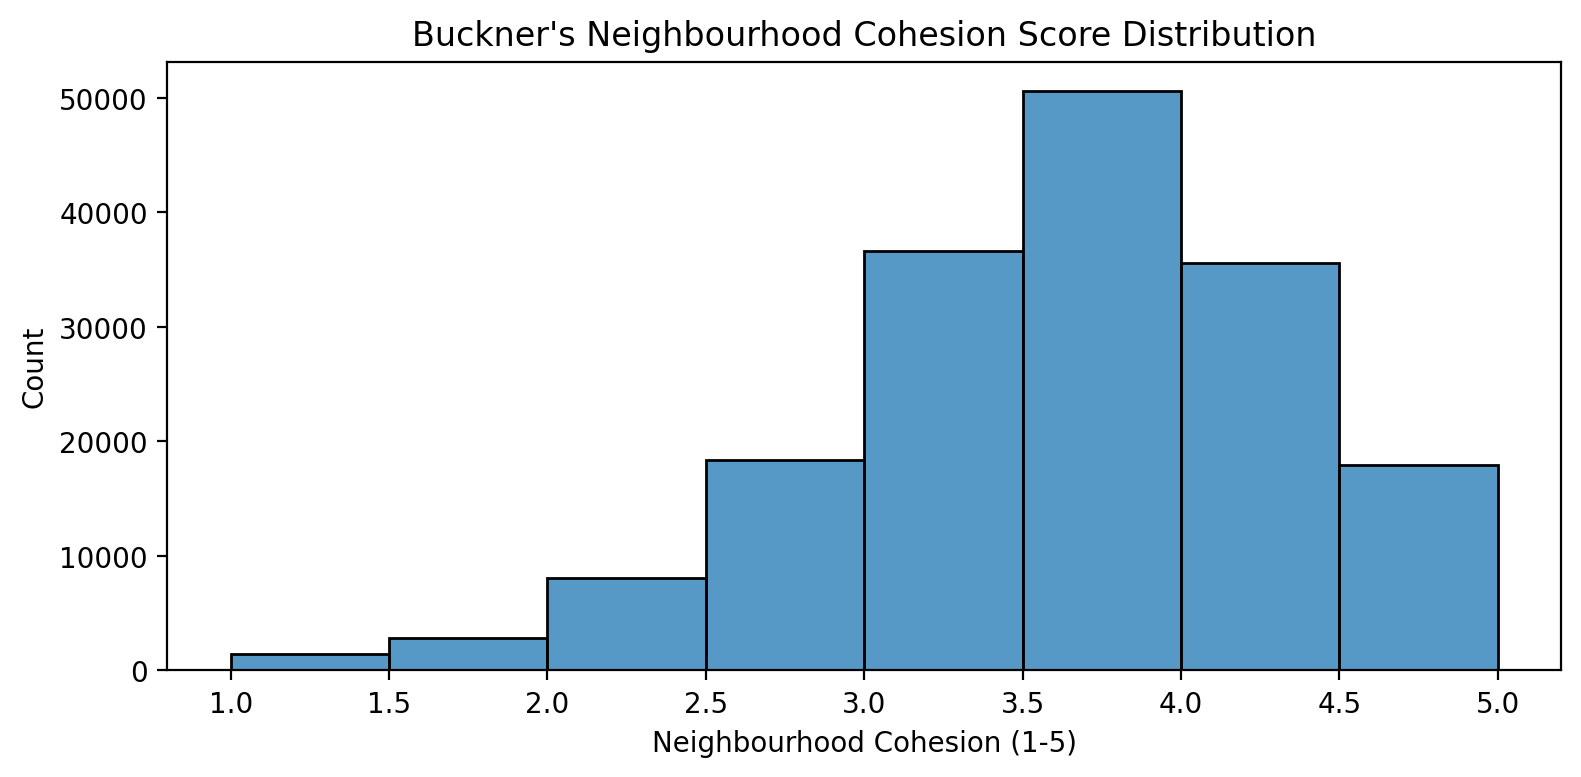

In [11]:
# Create histogram of nbrsnci_dv (neighbourhood cohesion)
col = 'nbrsnci_dv'
nbr_min = 1
nbr_max = 5

# bins of width 0.5, starting from the min value
bins = np.arange(nbr_min, nbr_max + 0.01, 0.5)

plt.figure(figsize=(8, 4))
sns.histplot(X[col], bins=bins, kde=False, color='C0')
plt.title("Buckner's Neighbourhood Cohesion Score Distribution")
plt.xlabel('Neighbourhood Cohesion (1-5)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



Location


Distribution of respondents by region:
                  Region  Count  Share
    South East (England)  21109   12.3
                  London  19521   11.4
    North West (England)  17651   10.3
                Scotland  14989    8.7
          East (England)  14985    8.7
    South West (England)  14244    8.3
 West Midlands (England)  13987    8.2
Yorkshire and The Humber  13954    8.1
 East Midlands (England)  12831    7.5
                   Wales  11344    6.6
        Northern Ireland  10298    6.0
    North East (England)   6612    3.9


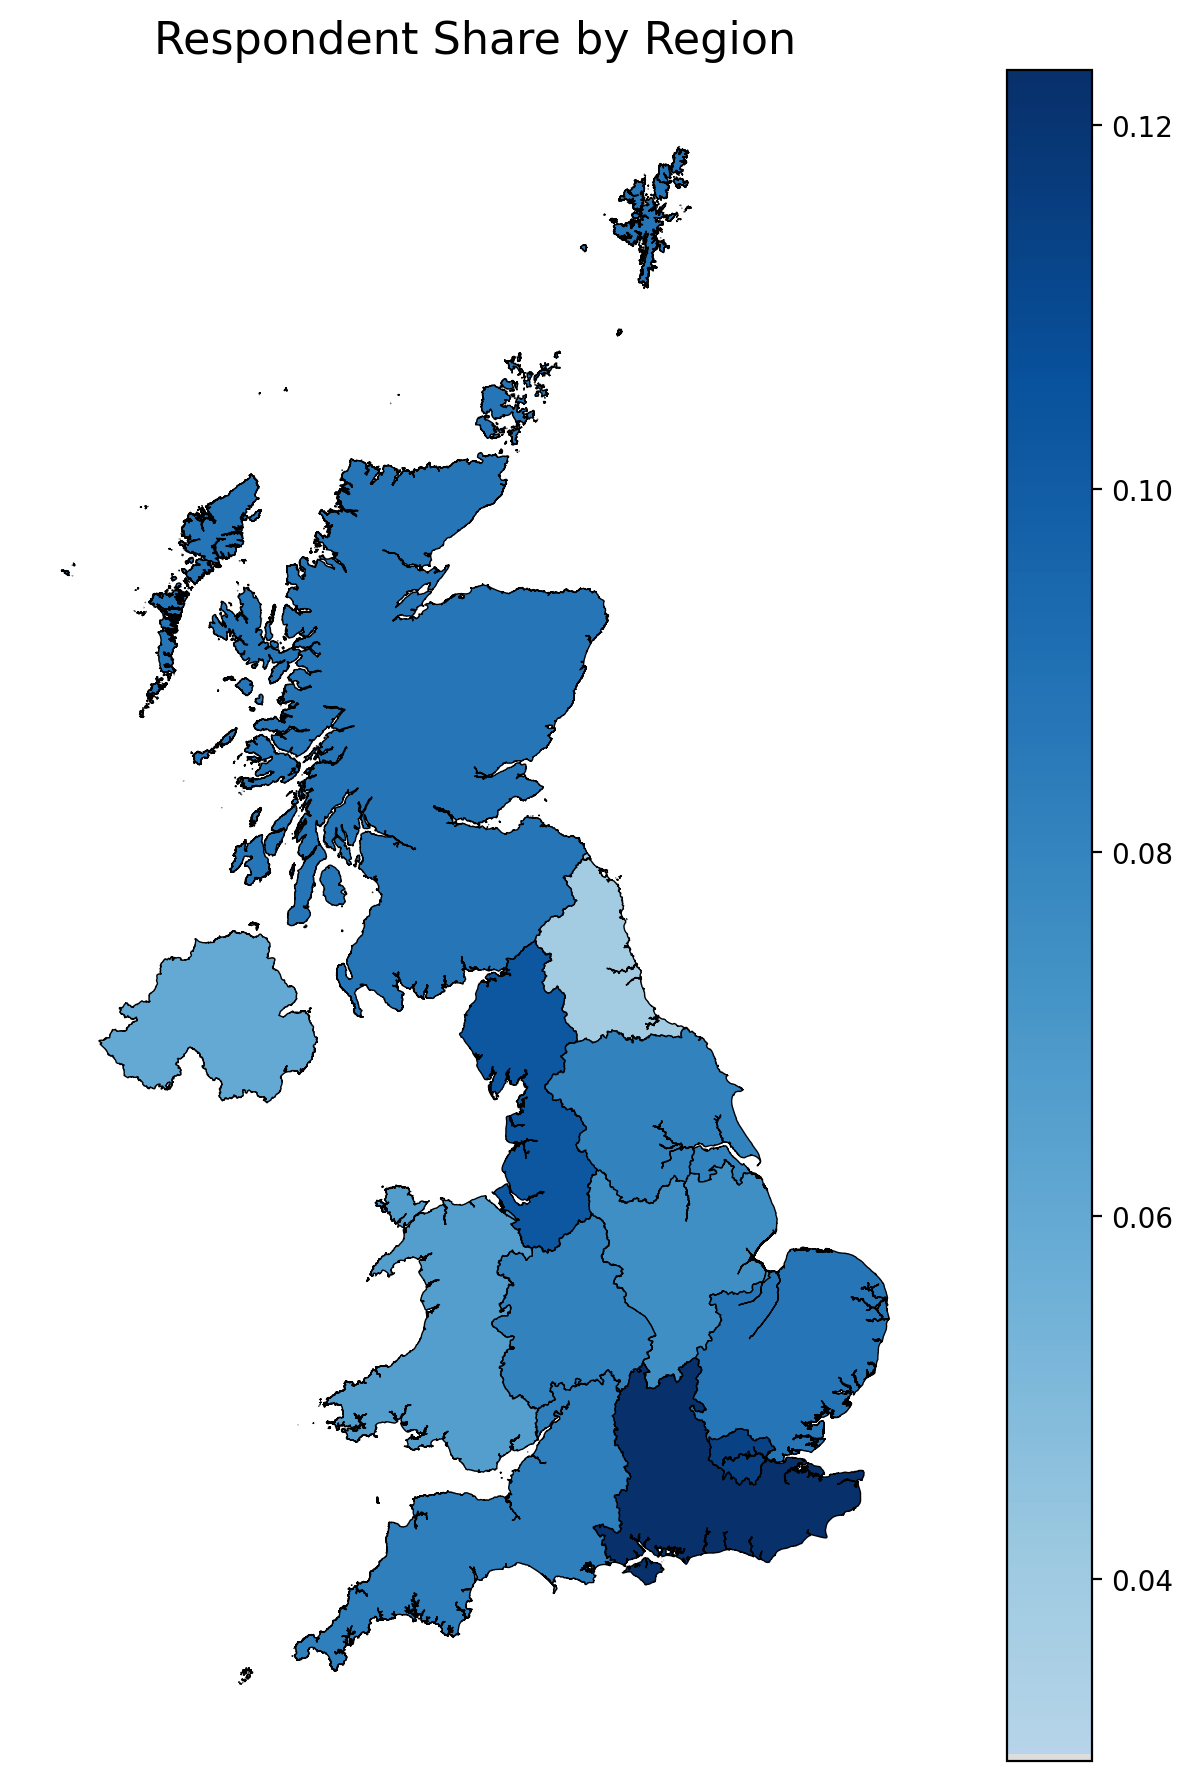

In [12]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt

# --- 1) Load shapes and standardise the name column ---
PATH_TO_GEOJSON = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/gor_dv.geojson"
NAME_COL = "ITL125NM"          # <- check with: print(gpd.read_file(PATH_TO_GEOJSON).columns)
regions = gpd.read_file(PATH_TO_GEOJSON)[[NAME_COL, "geometry"]].rename(columns={NAME_COL:"Region"})

# --- 2) Map gor_dv codes to the EXACT strings used in the GeoJSON ---
# ITL1 2025 names look like this:
code_to_label_geojson = {
    1: "North East (England)",
    2: "North West (England)",
    3: "Yorkshire and The Humber",
    4: "East Midlands (England)",
    5: "West Midlands (England)",
    6: "East (England)",
    7: "London",
    8: "South East (England)",
    9: "South West (England)",
    10: "Wales",
    11: "Scotland",
    12: "Northern Ireland"
}

# --- 3) Build a tidy distribution table (counts + shares) ---
gor = (X["gor_dv"].astype(int)
                 .map(code_to_label_geojson))   # convert codes -> GeoJSON labels

dist = (gor.value_counts()                  # count occurrences of each label
          .rename_axis("Region")            # name the index
          .reset_index(name="Count")        # turn into a DataFrame
          .sort_values("Count", ascending=False)) # sort by count descending
dist["Share"] = dist["Count"] / dist["Count"].sum() # compute share

print("\nDistribution of respondents by region:")
print(dist.assign(Share=lambda d: (d["Share"]*100).round(1)).to_string(index=False)) # display as percentages.

# --- 4) Merge onto the polygons and plot ---
gdf = regions.merge(dist, on="Region", how="left").fillna({"Count":0, "Share":0.0})
fig, ax = plt.subplots(figsize=(8, 9))

# Custom colormap: start at light grey, then blend into Blues

from matplotlib.colors import to_rgba

# Convert "#dddddd" to RGBA and concatenate with Blues colormap
grey_rgba = np.array([to_rgba("#dddddd")])
blues_rgba = plt.cm.Blues(np.linspace(0.3, 1, 256))
colors = np.vstack([grey_rgba, blues_rgba])
custom_cmap = LinearSegmentedColormap.from_list("grey_blues", colors, N=256)

# Set vmin to 0.03 (3%) so that 3% is not mapped to the lightest grey
norm = Normalize(vmin=0.03, vmax=gdf["Share"].max(), clip=True)

gdf.plot(
    column="Share",
    cmap=custom_cmap,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    norm=norm,
    ax=ax
)
ax.set_title("Respondent Share by Region", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

Job status

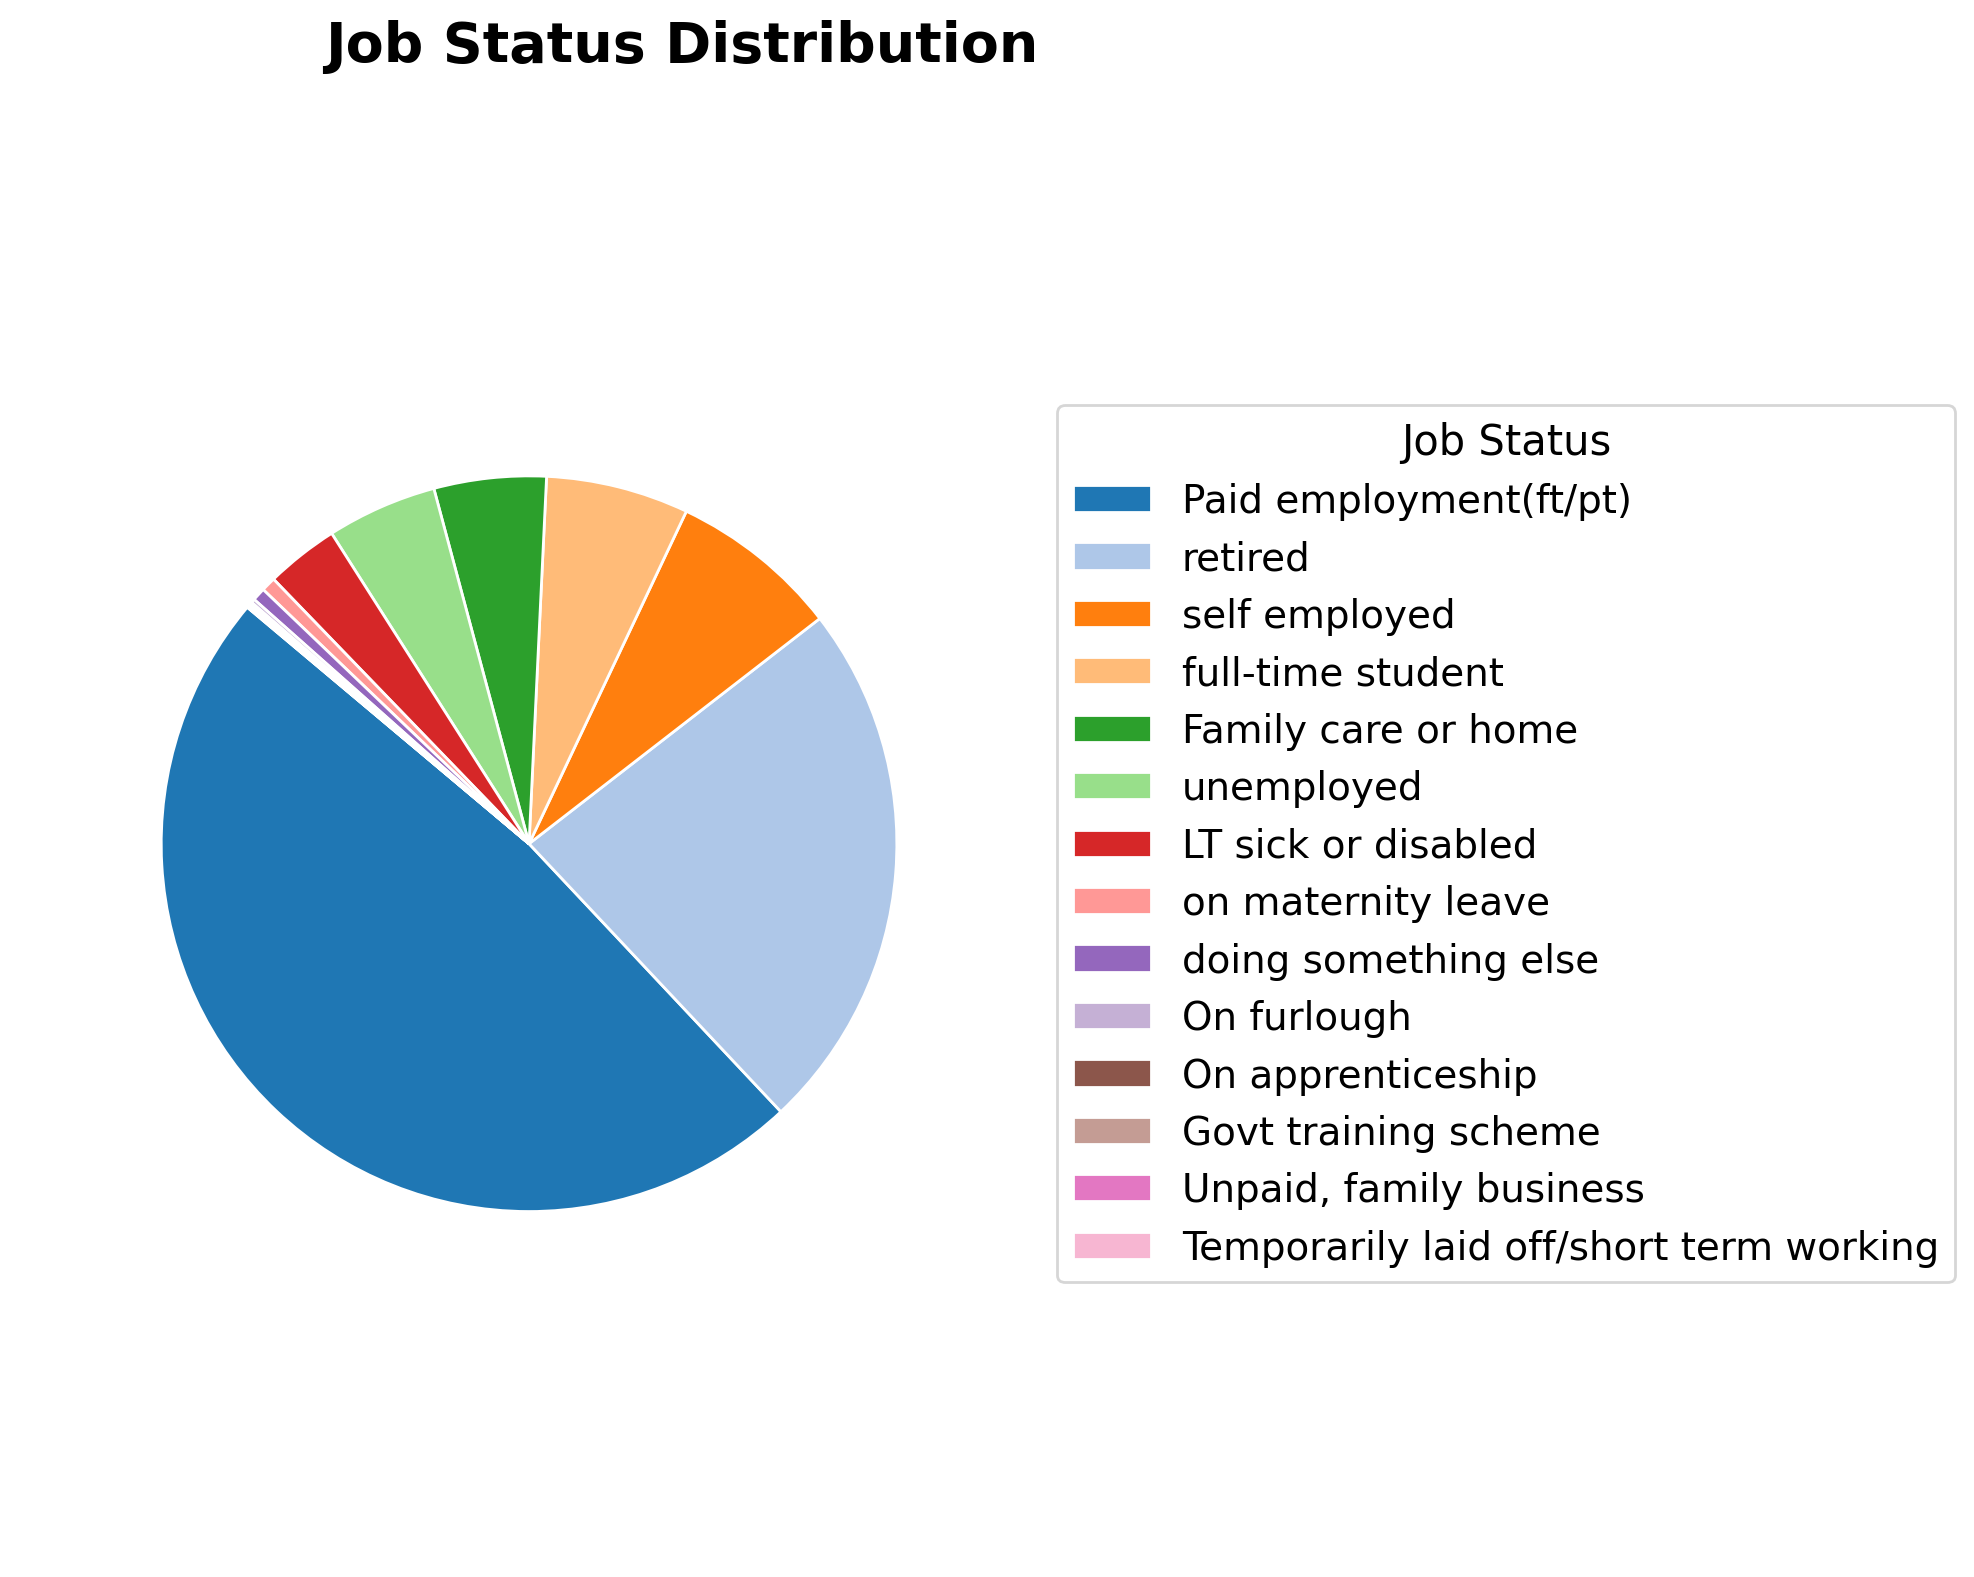

In [13]:
# Get job status value counts and labels
jb_counts = X['jbstat'].value_counts()
jb_labels_sorted = jb_counts.index.astype(int)
jb_sizes_sorted = jb_counts.values

# Get value labels from meta
jbstat_labelset = meta.variable_to_label.get('jbstat')
jbstat_labels = meta.value_labels.get(jbstat_labelset, {})
jb_labels_text = [jbstat_labels.get(code, str(code)) for code in jb_labels_sorted]

from matplotlib import cm

# Pie chart for job status: legend uses value labels from meta
cmap = plt.get_cmap('tab20')
pie_colors = [cmap(i) for i in range(len(jb_sizes_sorted))]

plt.figure(figsize=(10, 8))

wedges, _ = plt.pie(
    jb_sizes_sorted,
    labels=None,
    startangle=140,
    colors=pie_colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

plt.legend(wedges, jb_labels_text, title="Job Status", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=15)
plt.title("Job Status Distribution", fontsize=20, weight='bold', pad=25, loc='right')
plt.axis("equal")
plt.tight_layout()
plt.show()


## Bivariate analysis

Age vs Income (by sex)

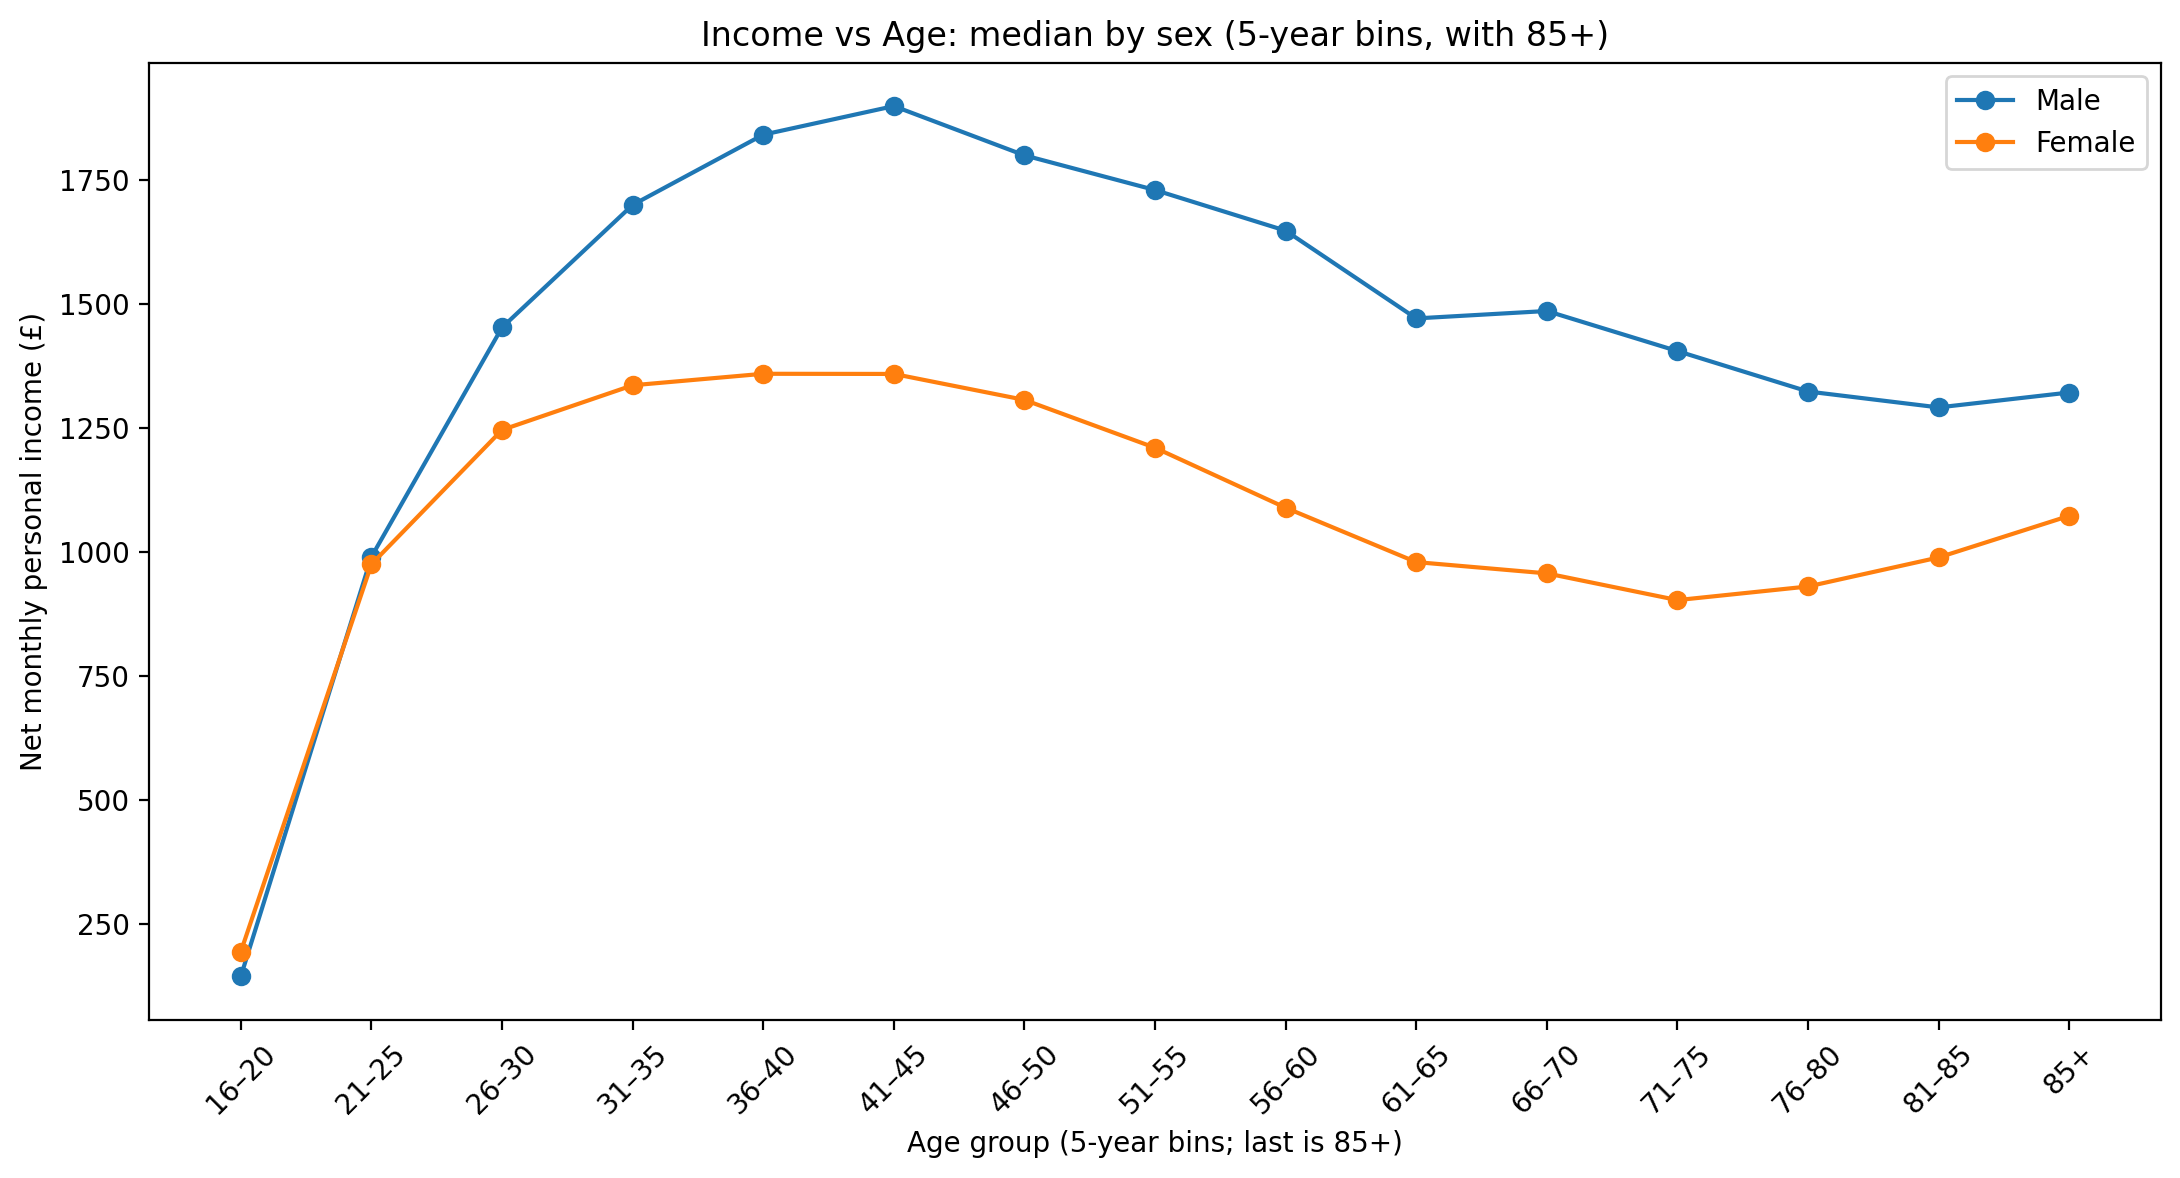

In [14]:
d = X.copy()

# --- 1) Define bins: 16–85 in 5-year steps, plus one open-ended 85+ bin ---
bins   = list(range(16, 87, 5)) + [120]        # last bin goes up to age 120
labels = [f"{b}–{b+4}" for b in range(16, 86, 5)] + ["85+"]

# --- 2) Helper to compute median by age-bin for one sex ---
def median_by_agebin(data, sex_code):
    sub = data.loc[data['sex_dv'] == sex_code, ['age_dv', 'fimnnet_dv']].copy()
    age_bin = pd.cut(sub['age_dv'], bins=bins, labels=labels, right=False)
    g = (
        sub.groupby(age_bin, observed=True)['fimnnet_dv']
           .median()
           .reindex(labels)  # keep bin order
    )
    return pd.DataFrame({
        'age_bin': labels,
        'median': g.values
    })

male   = median_by_agebin(d, 1)  # 1 = male
female = median_by_agebin(d, 2)  # 2 = female

# --- 3) Plot: two simple median lines with bin labels on x-axis ---
plt.figure(figsize=(11,6))
plt.plot(male['age_bin'],   male['median'],   marker='o', label='Male')
plt.plot(female['age_bin'], female['median'], marker='o', label='Female')

plt.xlabel('Age group (5-year bins; last is 85+)')
plt.ylabel('Net monthly personal income (£)')
plt.title('Income vs Age: median by sex (5-year bins, with 85+)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Wellbeing vs Age (by sex)

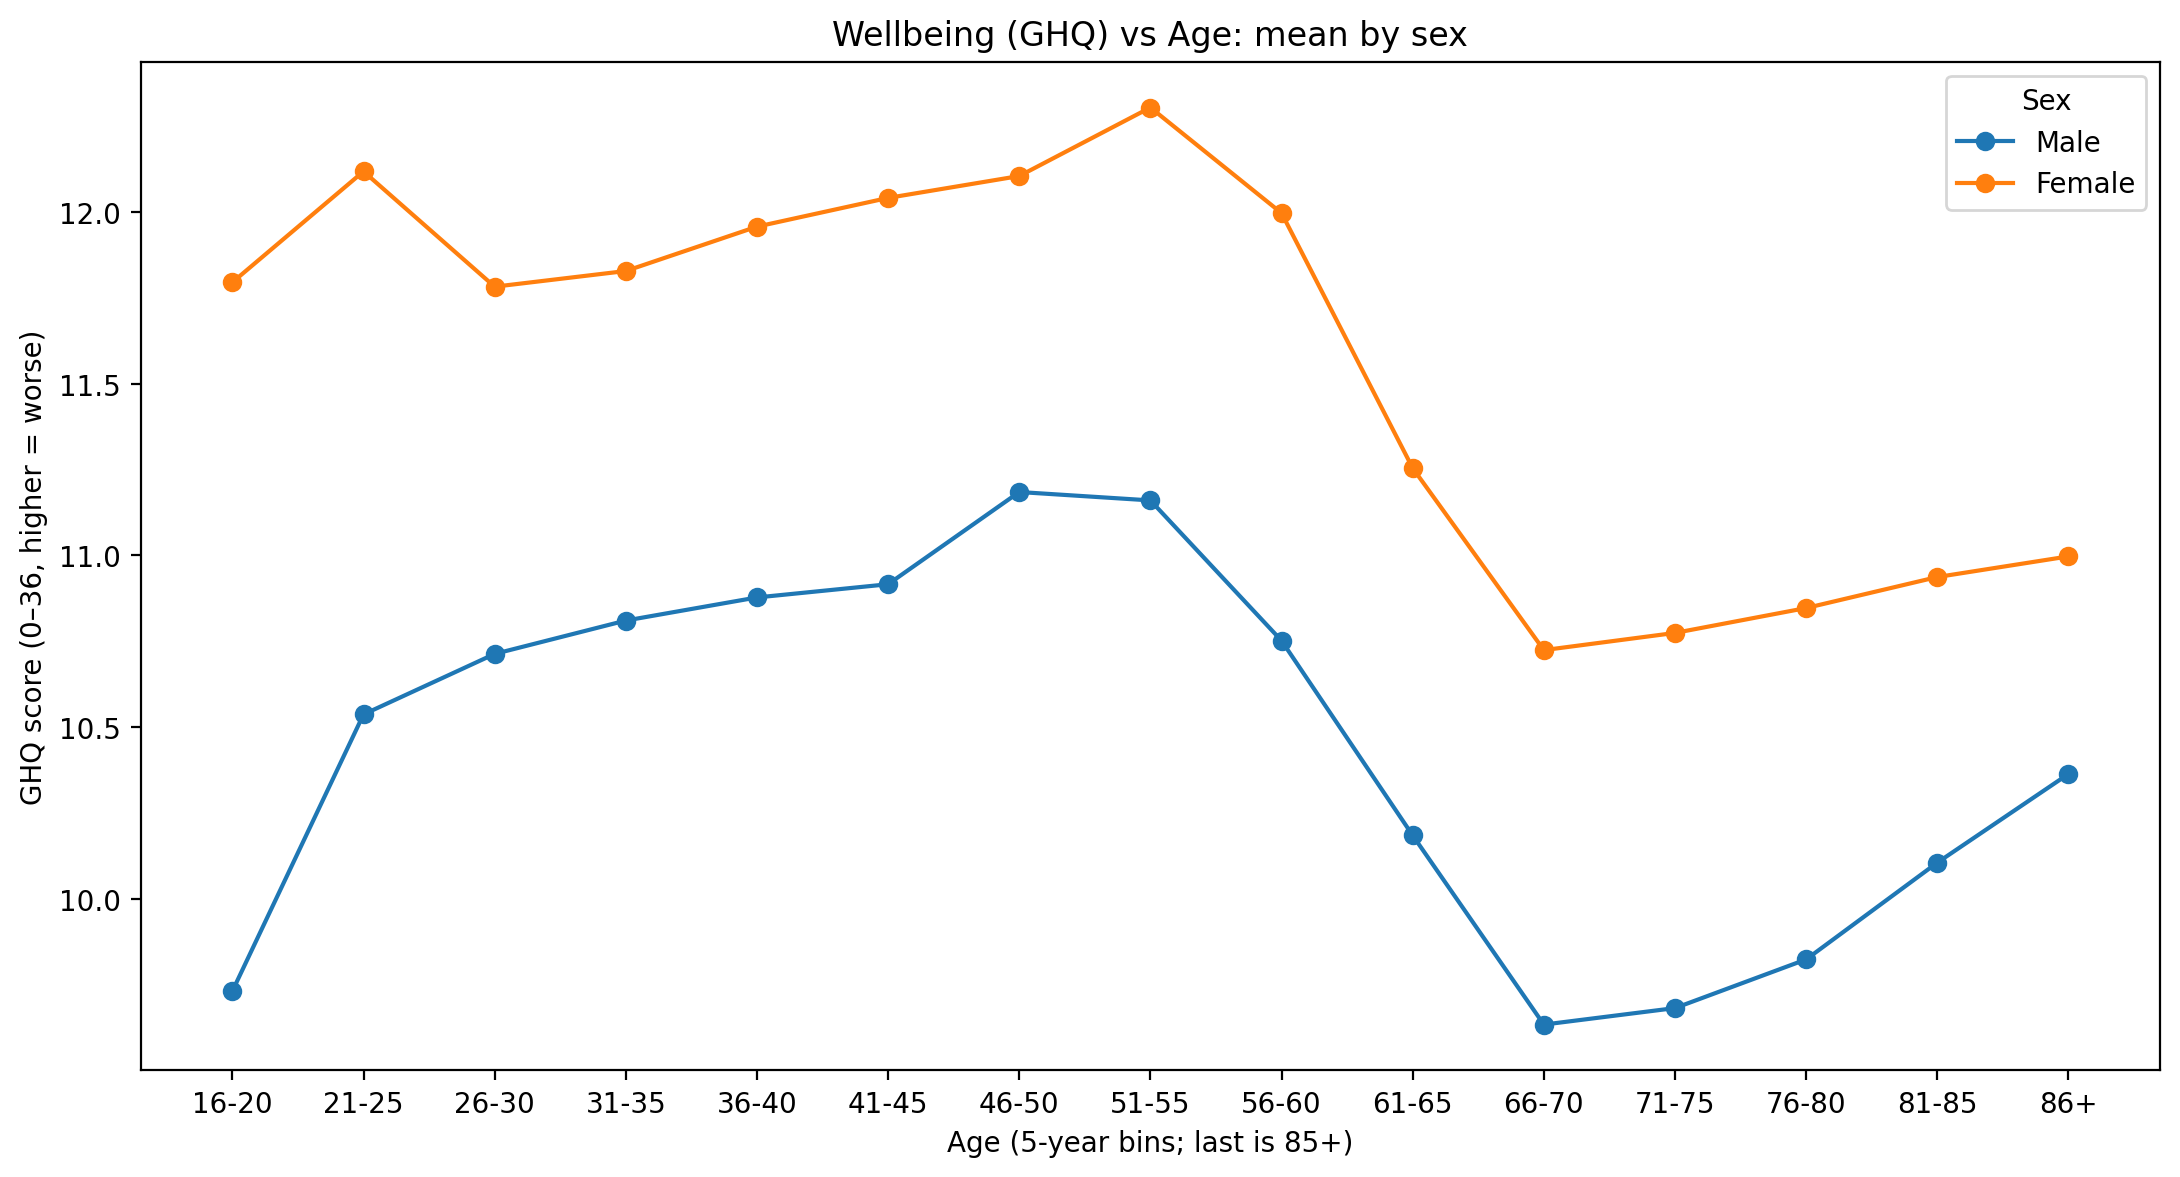

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- OPTIONS ----------
MIN_N_PER_BIN = 10      # hide bins with fewer observations
BINS = list(range(16, 87, 5)) + [120]   # 16–86 in 5-year bins, then one 86+ bin
BIN_LABELS = [f"{b}-{b+4}" for b in range(16, 86, 5)] + ["86+"]

# Use your main dataframe here
d = df.copy()   # or X.copy()

# Keep only relevant columns and drop missings
d = d[['age_dv', 'sex_dv', 'scghq1_dv']].dropna()
d = d[(d['scghq1_dv'] >= 0) & (d['scghq1_dv'] <= 36)]

# Make 5-year age bins (with a single 85+ bin)
d = d.assign(age_bin=pd.cut(d['age_dv'], bins=BINS, labels=BIN_LABELS, right=False))

def summarise_by_sex(data, sex_code):
    """Return mean and N of GHQ by age_bin for a given sex."""
    sub = data.loc[data['sex_dv'] == sex_code, ['age_bin', 'scghq1_dv']].copy()
    g = (sub.groupby('age_bin', observed=True)['scghq1_dv']
            .agg(mean='mean', n='count')
            .reindex(BIN_LABELS))  # preserve bin order
    return g

male   = summarise_by_sex(d, 1)   # 1 = male
female = summarise_by_sex(d, 2)   # 2 = female

# Apply mask for small bins
male_mask   = male['n']   >= MIN_N_PER_BIN
female_mask = female['n'] >= MIN_N_PER_BIN

x = np.arange(len(BIN_LABELS))

plt.figure(figsize=(11, 6))

# --- Male line (mean only) ---
plt.plot(x[male_mask], male.loc[male_mask, 'mean'], marker='o', label='Male')

# --- Female line (mean only) ---
plt.plot(x[female_mask], female.loc[female_mask, 'mean'], marker='o', label='Female')

# Cosmetics
plt.xticks(ticks=x, labels=BIN_LABELS, rotation=0)
plt.xlabel('Age (5-year bins; last is 85+)')
plt.ylabel('GHQ score (0–36, higher = worse)')
plt.title('Wellbeing (GHQ) vs Age: mean by sex')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()


Wellbeing vs Income (by sex)

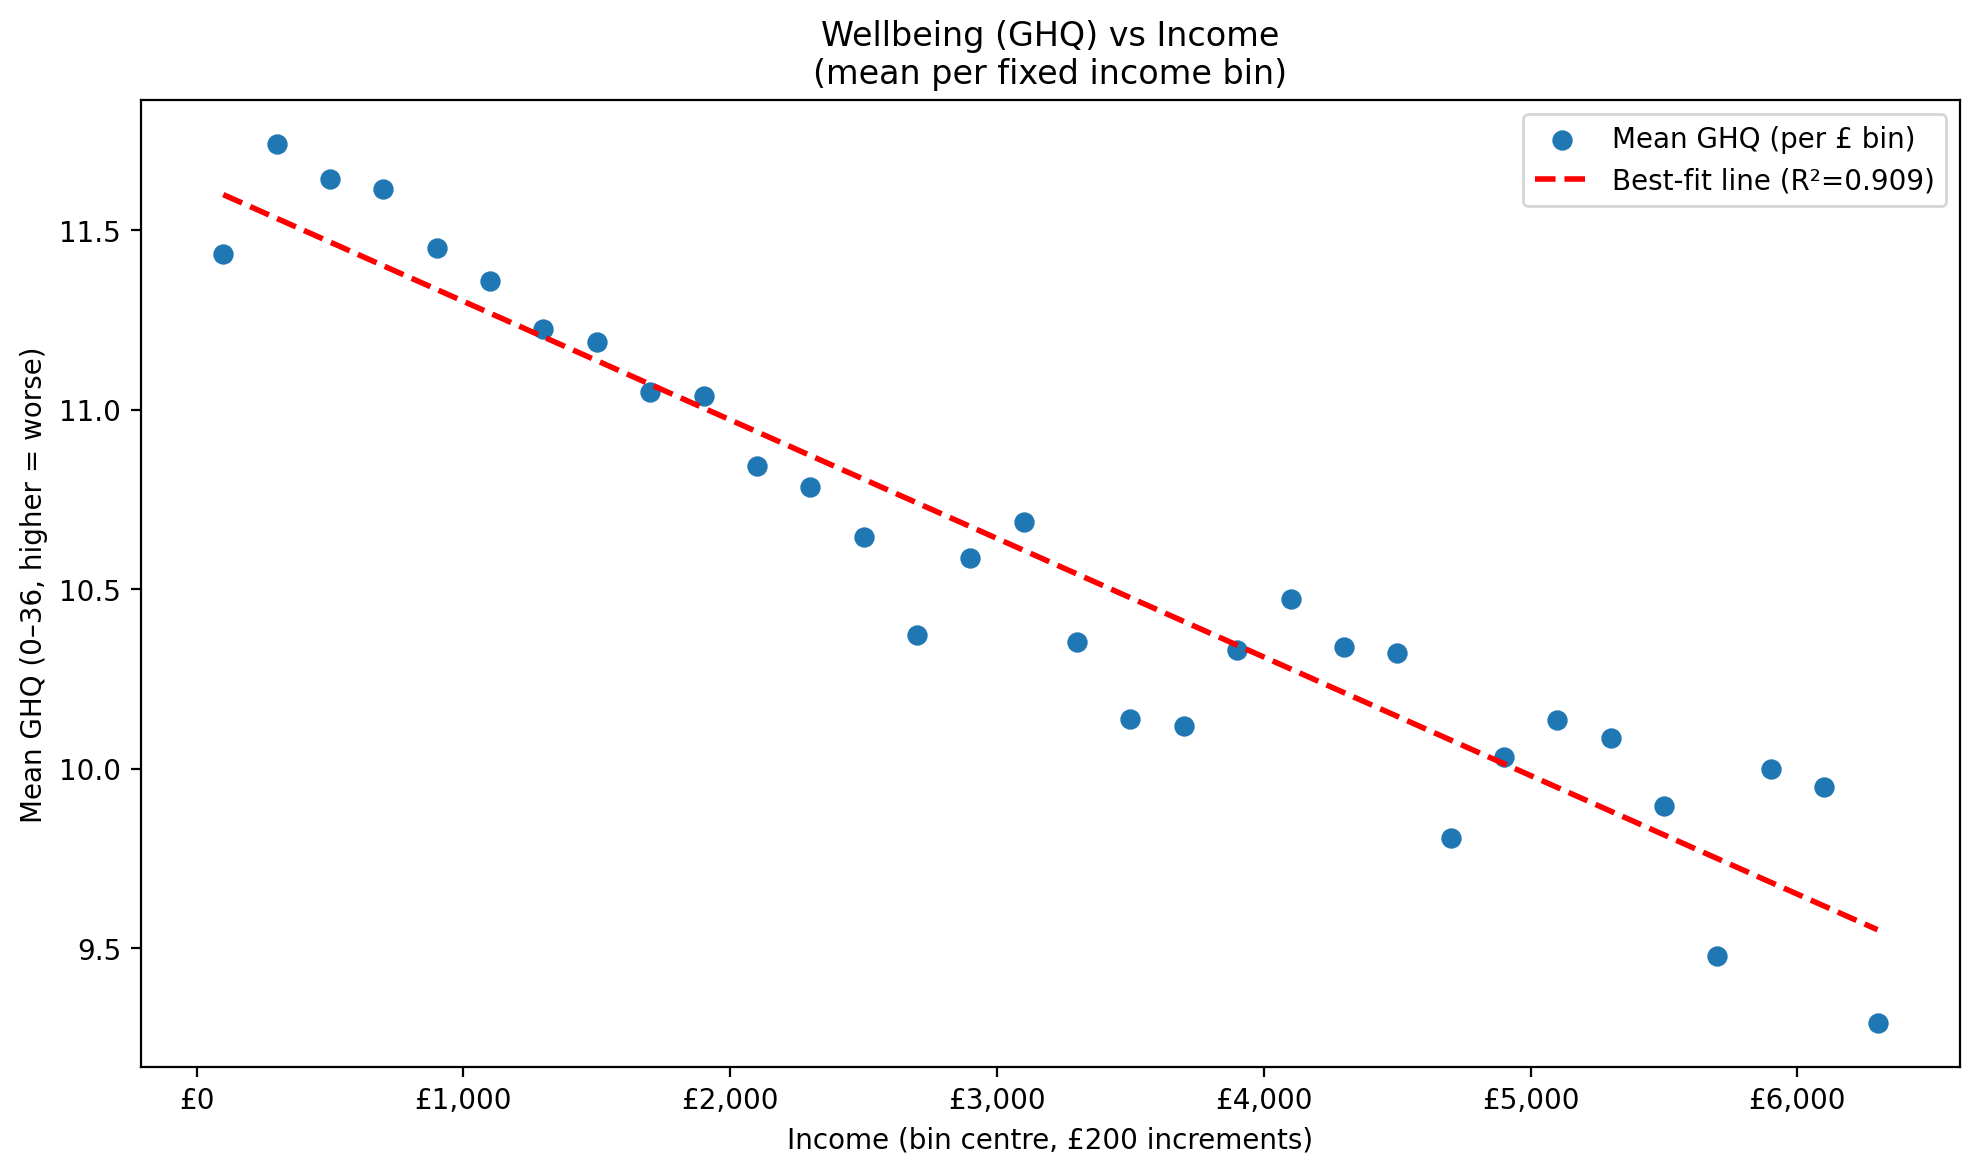

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ===== settings =====
INCOME_COL = 'fimnnet_dv'   # or 'fihhmnnet1_dv' for household income
BIN_WIDTH  = 200            # £ increments for fixed-width bins
MIN_N      = 50             # drop bins with fewer than MIN_N respondents
# =====================

# 1) Clean
d = df[[INCOME_COL, 'scghq1_dv']].dropna().copy()
d = d[(d['scghq1_dv'].between(0, 36)) & (d[INCOME_COL] > 0)]
p99 = d[INCOME_COL].quantile(0.99)        # trim extreme top 1%
d = d[d[INCOME_COL] <= p99]

# 2) Fixed-width bins across the sample
low  = (d[INCOME_COL].min() // BIN_WIDTH) * BIN_WIDTH
high = (p99 // BIN_WIDTH + 1) * BIN_WIDTH
bins = np.arange(low, high + BIN_WIDTH, BIN_WIDTH)

d['inc_bin'] = pd.cut(d[INCOME_COL], bins=bins, include_lowest=True)

# 3) Mean GHQ per bin (+ N)
g = (d.groupby('inc_bin', observed=True)['scghq1_dv']
       .agg(mean_ghq='mean', n='count')
       .reset_index())

# 4) Keep only reasonably-populated bins
g = g[g['n'] >= MIN_N].copy()
g['bin_mid'] = pd.IntervalIndex(g['inc_bin']).mid

# 5) Regression on the bin means
x = g['bin_mid'].values
y = g['mean_ghq'].values
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# R^2 calculation
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot

# For plotting line
xgrid = np.linspace(x.min(), x.max(), 200)
ygrid = m * xgrid + b

# 6) Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, s=40, color='C0', label='Mean GHQ (per £ bin)')
ax.plot(xgrid, ygrid, 'r--', lw=2,
        label=f'Best-fit line (R²={r2:.3f})')

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))
ax.set_xlabel(f'Income (bin centre, £{BIN_WIDTH} increments)')
ax.set_ylabel('Mean GHQ (0–36, higher = worse)')
ax.set_title('Wellbeing (GHQ) vs Income\n(mean per fixed income bin)')
ax.legend()
plt.tight_layout()
plt.show()

Wellbeing vs informal institutions

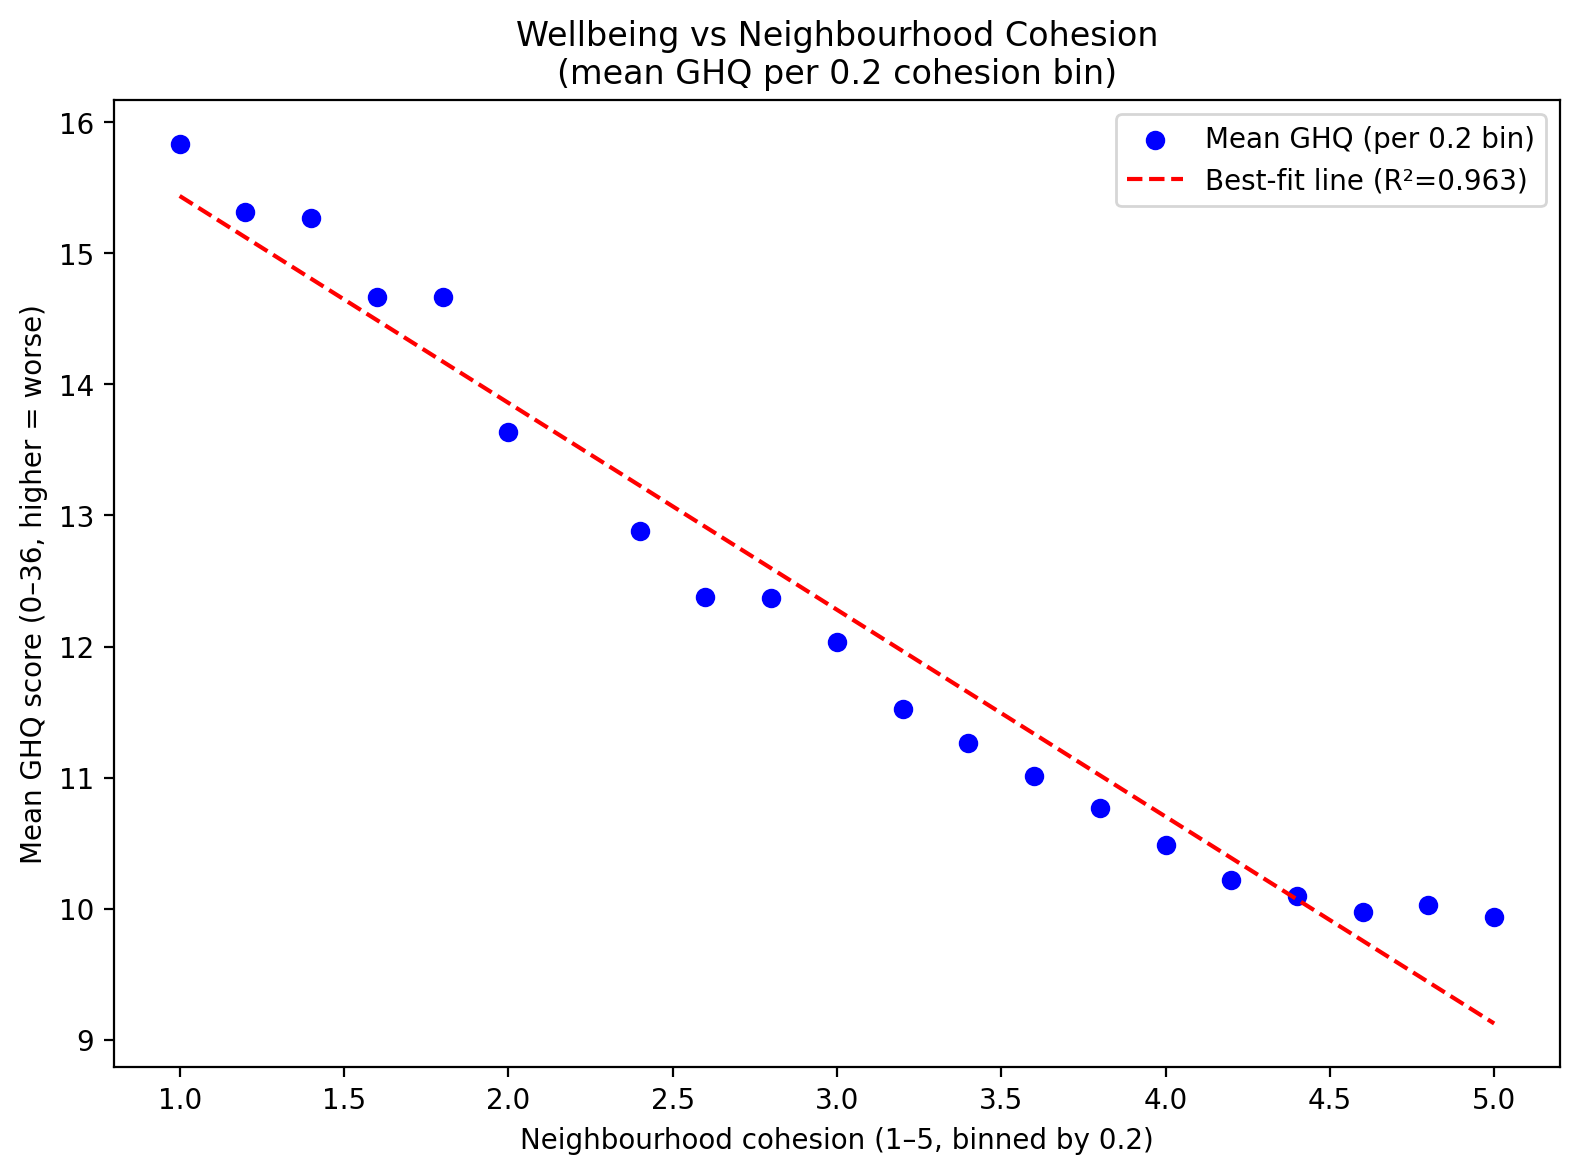

In [25]:
# 1) Clean: keep valid values
d = df[['nbrsnci_dv','scghq1_dv']].copy()
d = d[(d['nbrsnci_dv'].between(0,5)) & (d['scghq1_dv'].between(0,36))]

# 2) Bin neighbourhood cohesion into 0.2-width bins
d['cohesion_bin'] = (d['nbrsnci_dv'] / 0.2).round() * 0.2

# 3) Compute mean + median GHQ per bin (choose one to plot)
g = d.groupby('cohesion_bin')['scghq1_dv'].agg(['mean','median','count']).reset_index()

# Drop bins with very low N
g = g[g['count'] >= 20]

# 4) Scatter plot of mean wellbeing per bin
plt.figure(figsize=(8,6))
plt.scatter(g['cohesion_bin'], g['mean'], color='blue', label='Mean GHQ (per 0.2 bin)')

# 5) Add best-fit regression line across the means
z = np.polyfit(g['cohesion_bin'], g['mean'], 1)
p = np.poly1d(z)

# R²
y_true = g['mean']
y_pred = p(g['cohesion_bin'])
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - y_true.mean())**2)
r2 = 1 - ss_res/ss_tot

plt.plot(g['cohesion_bin'], y_pred, "r--", label=f'Best-fit line (R²={r2:.3f})')

plt.xlabel("Neighbourhood cohesion (1–5, binned by 0.2)")
plt.ylabel("Mean GHQ score (0–36, higher = worse)")
plt.title("Wellbeing vs Neighbourhood Cohesion\n(mean GHQ per 0.2 cohesion bin)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Correlation coefficient between neighbourhood cohesion and GHQ score
corr = d['nbrsnci_dv'].corr(d['scghq1_dv'])
print(f"Correlation coefficient between neighbourhood cohesion and GHQ score: {corr:.3f}")

Correlation coefficient between neighbourhood cohesion and GHQ score: -0.182


Wellbeing by region


Average GHQ by region (higher = worse):
                  Region  mean_ghq     n
 West Midlands (England)     11.51 13987
    North West (England)     11.38 17651
    North East (England)     11.37  6612
                   Wales     11.35 11344
Yorkshire and The Humber     11.29 13954
 East Midlands (England)     11.19 12831
                  London     11.17 19521
          East (England)     11.08 14985
    South West (England)     11.07 14244
    South East (England)     11.00 21109
                Scotland     10.98 14989
        Northern Ireland     10.91 10298


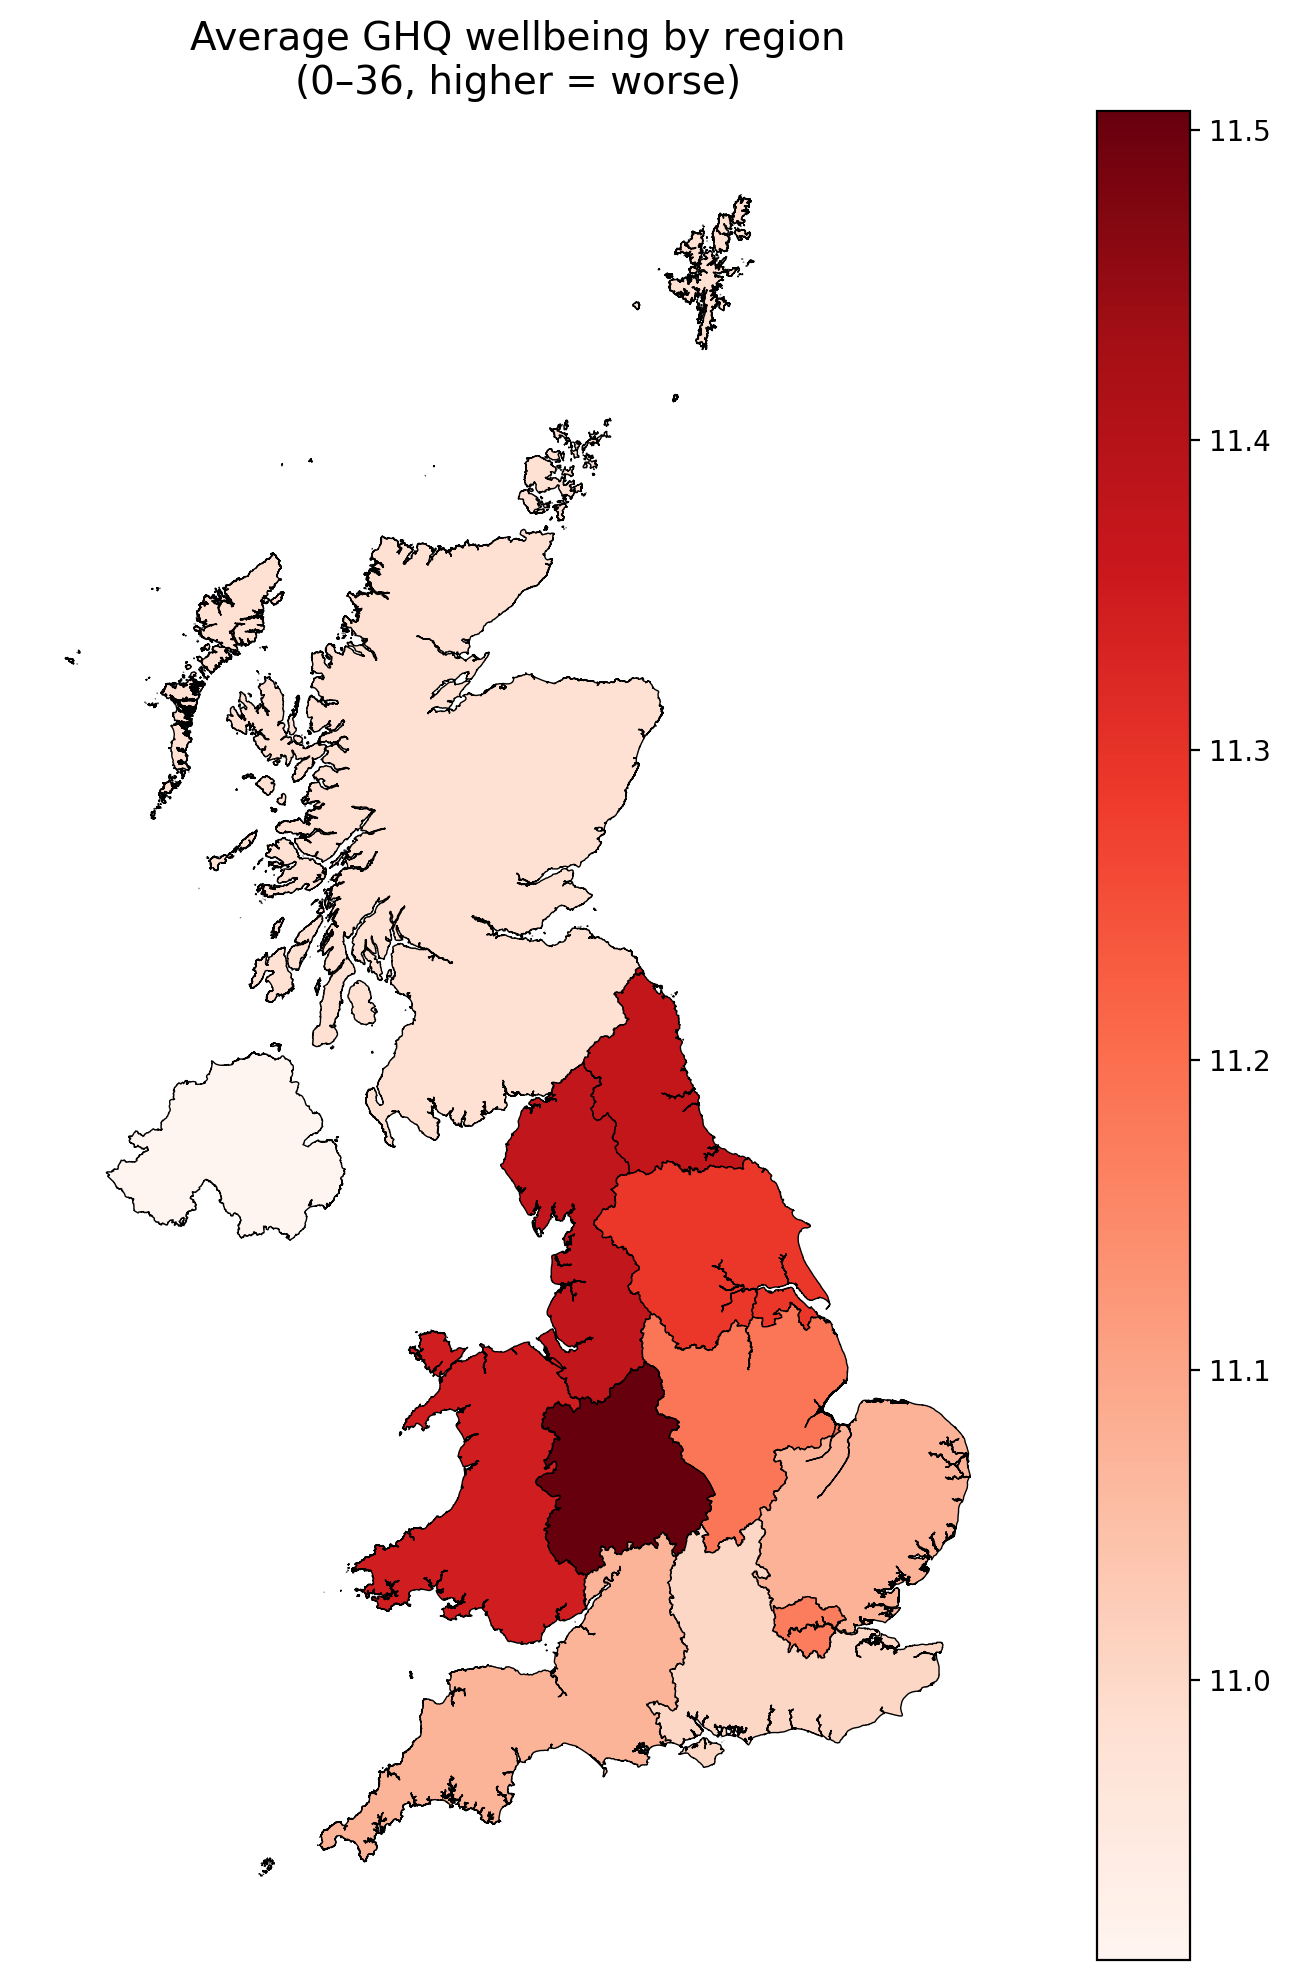

In [19]:
PATH_TO_GEOJSON = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/gor_dv.geojson"
NAME_COL = "ITL125NM"  # change if your GeoJSON uses a different name column

# 1) Load regions and standardise the name column
regions = gpd.read_file(PATH_TO_GEOJSON)[[NAME_COL, "geometry"]].rename(columns={NAME_COL: "Region"})

# 2) Map UKHLS region codes -> EXACT GeoJSON labels (ITL1 2025 style)
code_to_label_geojson = {
    1: "North East (England)",
    2: "North West (England)",
    3: "Yorkshire and The Humber",
    4: "East Midlands (England)",
    5: "West Midlands (England)",
    6: "East (England)",
    7: "London",
    8: "South East (England)",
    9: "South West (England)",
    10: "Wales",
    11: "Scotland",
    12: "Northern Ireland",
}

# 3) Build tidy table: mean GHQ and N by region
d = df[["gor_dv", "scghq1_dv"]].copy()  # or X if both columns live there
d["gor_dv"] = d["gor_dv"].replace({-9: np.nan})
d["scghq1_dv"] = d["scghq1_dv"].replace({-9: np.nan, -8: np.nan, -7: np.nan})
d = d.dropna()

d["Region"] = d["gor_dv"].astype(int).map(code_to_label_geojson)

wb = (
    d.groupby("Region", observed=True)["scghq1_dv"]
      .agg(mean_ghq="mean", n="count")
      .reset_index()
      .sort_values("mean_ghq", ascending=False)
)

# 4) Print a quick table (higher GHQ = worse wellbeing)
print("\nAverage GHQ by region (higher = worse):")
print(wb.assign(mean_ghq=lambda x: x["mean_ghq"].round(2)).to_string(index=False))

# 5) Merge with polygons; regions with no data get NaN
gdf = regions.merge(wb, on="Region", how="left")

# 6) Plot: sequential red scale (darker red = worse wellbeing)
fig, ax = plt.subplots(figsize=(8.5, 10))
gdf.plot(
    column="mean_ghq",
    cmap="Reds",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    ax=ax,
)
ax.set_title("Average GHQ wellbeing by region\n(0–36, higher = worse)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

# (optional) sanity checks for name mismatches
not_in_map = set(wb["Region"]) - set(regions["Region"])
if not_in_map:
    print("\nWarning: in data but not in map ->", not_in_map)
not_in_data = set(regions["Region"]) - set(wb["Region"])
if not_in_data:
    print("Note: in map but no data ->", not_in_data)

## Multivariate analysis

### Regression models

#### Ordinary Least Squares (OLS) regression

In [20]:
# Run standard linear regression and show coefficients with p-values, sorted by absolute coefficient

X_sm = sm.add_constant(X_processed)
model = sm.OLS(Y_processed, X_sm).fit()
results_summary = model.summary2().tables[1]

results_summary = results_summary.rename(columns={"Coef.": "Coefficient", "P>|t|": "P-value"})
results_summary = results_summary.reset_index().rename(columns={"index": "Variable"})
results_summary["Abs_Coefficient"] = results_summary["Coefficient"].abs()
results_summary = results_summary.sort_values(by="Abs_Coefficient", ascending=False)

#reset index
results_summary = results_summary.reset_index(drop=True)

results_summary[["Variable", "Coefficient", "P-value"]]

,Variable,Coefficient,P-value
0,const,9.835876,4.064969e-12
1,jbstat_8,5.588488,0.000000e+00
2,jbstat_13,3.371597,3.749201e-05
3,marstat_dv_5,3.094933,2.913891e-02
4,marstat_dv_4,2.474926,8.060437e-02
5,health,-2.266035,0.000000e+00
6,jbstat_3,2.256533,1.850319e-201
7,jbstat_12,2.215691,2.632242e-13
8,marstat_dv_3,2.145524,1.299588e-01
9,marstat_dv_2,2.024508,1.527877e-01


#### LASSO regression

The LASSO estimator the set of regression coefficients that minimises the regularised least squares objective:

$$
\hat{\beta}^{\text{lasso}}
= \arg \min_{\beta} \left\{
\frac{1}{2n} \sum_{i=1}^{n} \big( y_i - x_i^\top \beta \big)^2
+ \lambda \sum_{j=1}^{p} |\beta_j|
\right\}
$$

<u>Explanation</u>

The **first term**  

  $ \frac{1}{2n} \sum_{i=1}^{n} ( y_i - x_i^\top \beta )^2 $  
  
is the mean squared error → it measures how well the model fits the data.  

The **second term**  
 
 $ \lambda \sum_{j=1}^{p} |\beta_j| $  

is the **L1 penalty**, which shrinks coefficients towards zero.  

**Effect of λ (lambda):**  
  - Small λ → little shrinkage, model behaves like OLS.  
  - Large λ → more shrinkage, many coefficients become exactly 0 (feature selection).  

In [21]:
# Lasso regression with cross-validation

from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np

# ---- config ---------------------------------------------------------------
CONTINUOUS = ['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']

def parse_dummy(colname: str):
    """
    If column is a dummy like 'jbstat_8', return (base_var, 8) else (None, None).
    Uses rsplit so bases with underscores still work.
    """
    if '_' not in colname:
        return None, None
    base, suffix = colname.rsplit('_', 1)
    return (base, int(suffix)) if suffix.lstrip('-').isdigit() else (None, None)

def value_label_for(base_var: str, code: int, meta):
    """
    meta.variable_to_label maps var -> labelset name
    meta.value_labels maps labelset name -> {code: label}
    """
    labelset = meta.variable_to_label.get(base_var)
    if not labelset:
        return None
    return meta.value_labels.get(labelset, {}).get(code)

def var_label(var: str, meta):
    """Human label for a column, including category if it’s a dummy."""
    base, code = parse_dummy(var)
    if base is None:  # continuous or already-binary (0/1) variable
        return meta.column_names_to_labels.get(var, var)

    base_label = meta.column_names_to_labels.get(base, base)
    cat_label = value_label_for(base, code, meta)
    if cat_label is None:
        cat_label = str(code)
    return f"{base_label}: {cat_label}"

def category_only(var: str, meta):
    """Category text for the 'Category' column; empty for non-dummies."""
    base, code = parse_dummy(var)
    if base is None:
        return ""
    cat_label = value_label_for(base, code, meta)
    return cat_label if cat_label is not None else f"Category {code}"

# ---- fit model ------------------------------------------------------------
alphas = np.logspace(-10, 1, 100)  # Range of alpha values to try
lasso = LassoCV(cv=10, random_state=0, alphas=alphas, max_iter=200000, tol=1e-5)
lasso.fit(X_processed, Y_processed)

# ---- build coefficient table ---------------------------------------------
coef_df = pd.DataFrame({
    "Variable": X_processed.columns,
    "Coefficient": lasso.coef_
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df["Label"]    = coef_df["Variable"].apply(lambda v: var_label(v, meta))
coef_df["Category"] = coef_df["Variable"].apply(lambda v: category_only(v, meta))

# keep only non-zeros (Lasso makes some exactly zero)
non_zero = coef_df.loc[coef_df["Coefficient"] != 0].sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

print(f"Number of non-zero coefficients: {len(non_zero)}")

# Print the name of the zero coefficients
zero_coeffs = coef_df.loc[coef_df["Coefficient"] == 0, "Variable"].tolist()
print("Variables with zero coefficients (excluded by Lasso):")
print(zero_coeffs)

# print the chosen alpha
print(f"Chosen alpha: {lasso.alpha_}")

display_cols = ["Variable", "Coefficient", "Label", "Category"]
non_zero[display_cols].head(60)


Number of non-zero coefficients: 58
Variables with zero coefficients (excluded by Lasso):
['marstat_dv_2']
Chosen alpha: 0.00021544346900318823


,Variable,Coefficient,Label,Category
0,jbstat_8,5.573954,Current economic activity: LT sick or disabled,LT sick or disabled
1,jbstat_13,2.414301,Current economic activity: Temporarily laid off/short term working,Temporarily laid off/short term working
2,health,-2.266443,Long-standing illness or disability,
3,jbstat_3,2.243938,Current economic activity: unemployed,unemployed
4,jbstat_12,2.079952,Current economic activity: On furlough,On furlough
5,sex_dv,1.147049,"Sex, derived",
6,jbstat_97,1.121860,Current economic activity: doing something else,doing something else
7,marstat_dv_5,1.057442,Harmonised de facto marital status: Separated (incl. from civil partner),Separated (incl. from civil partner)
8,ethn_dv_15,-0.963344,Ethnic group (derived from multiple sources): african,african
9,nbrsnci_dv,-0.932275,"Buckner's Neighbourhood Cohesion Instrument, short (α= .88)",


Interestingly, the chosen alpha is very very SMALL, indicating that very little regularization is being applied. This suggests that most of the features are relevant to predicting the target variable.

We can show in the following cell how decreasing alpha improves the cross-validation MSE. Usually, if there are a lot of irrelevant features, we would expect the CV MSE to increase again at very low alpha values (i.e. overfitting). However, in this case, the CV MSE continues to decrease as alpha decreases, suggesting that most features are relevant.

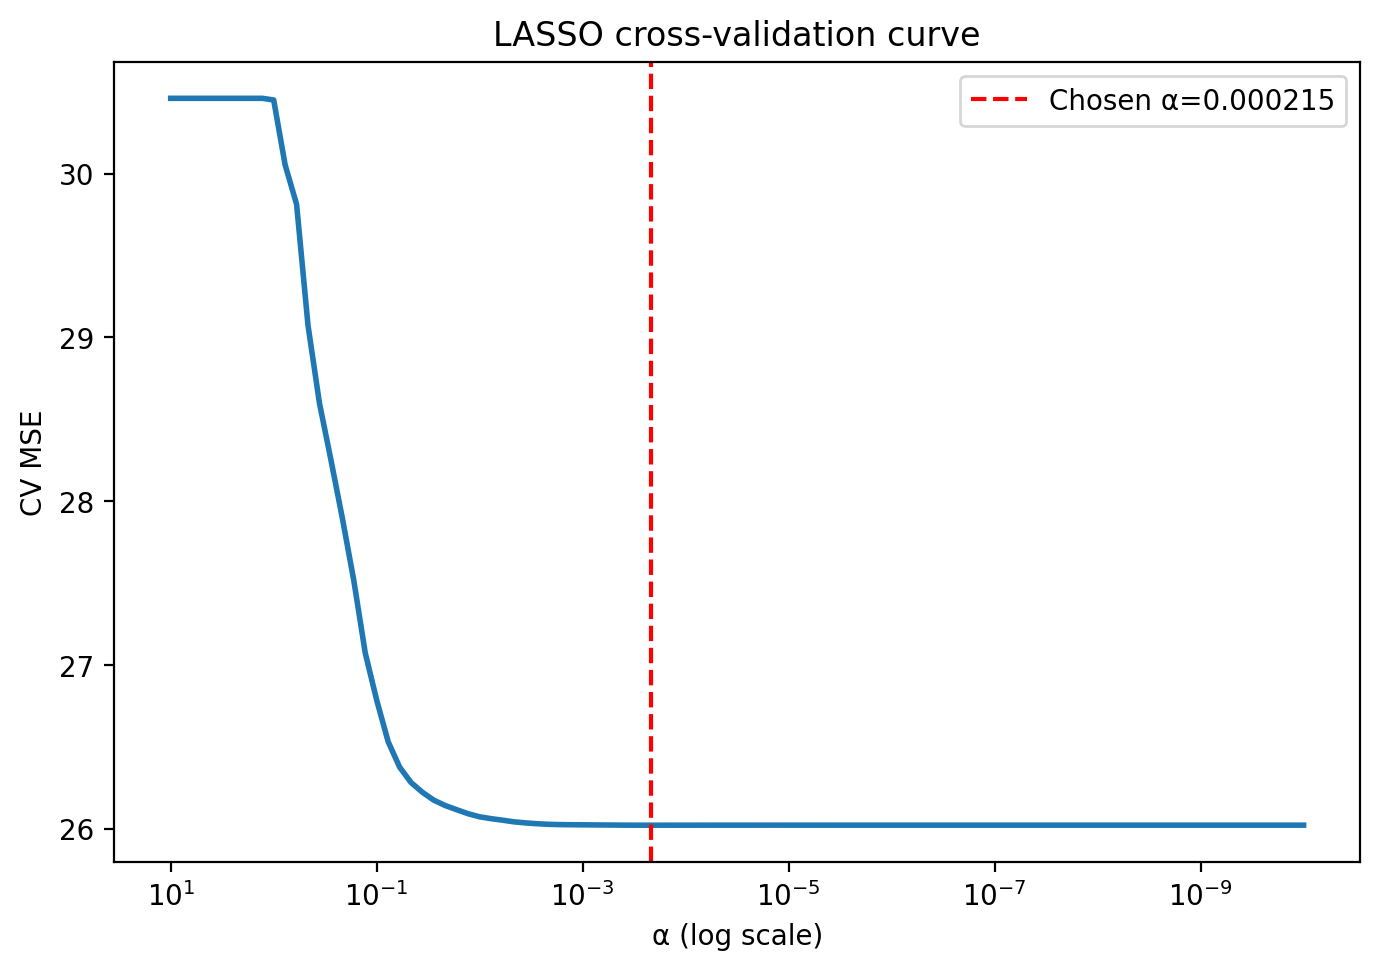

In [22]:
import numpy as np, matplotlib.pyplot as plt

mean_mse = lasso.mse_path_.mean(axis=1)
std_mse  = lasso.mse_path_.std(axis=1)
alphas   = lasso.alphas_                        

best_a = lasso.alpha_
best_i = np.argmin(mean_mse)

plt.figure(figsize=(7,5))
plt.plot(alphas, mean_mse, lw=2)
plt.axvline(best_a, ls='--', color='red', label=f'Chosen α={best_a:.3g}')
plt.xscale('log')
plt.gca().invert_xaxis()  # standard LASSO plotting convention
plt.xlabel('α (log scale)'); plt.ylabel('CV MSE')
plt.title('LASSO cross-validation curve')
plt.legend(); plt.tight_layout(); plt.show()

We can also visualise the regularisation path, which shows how the coefficients change as a function of alpha. 

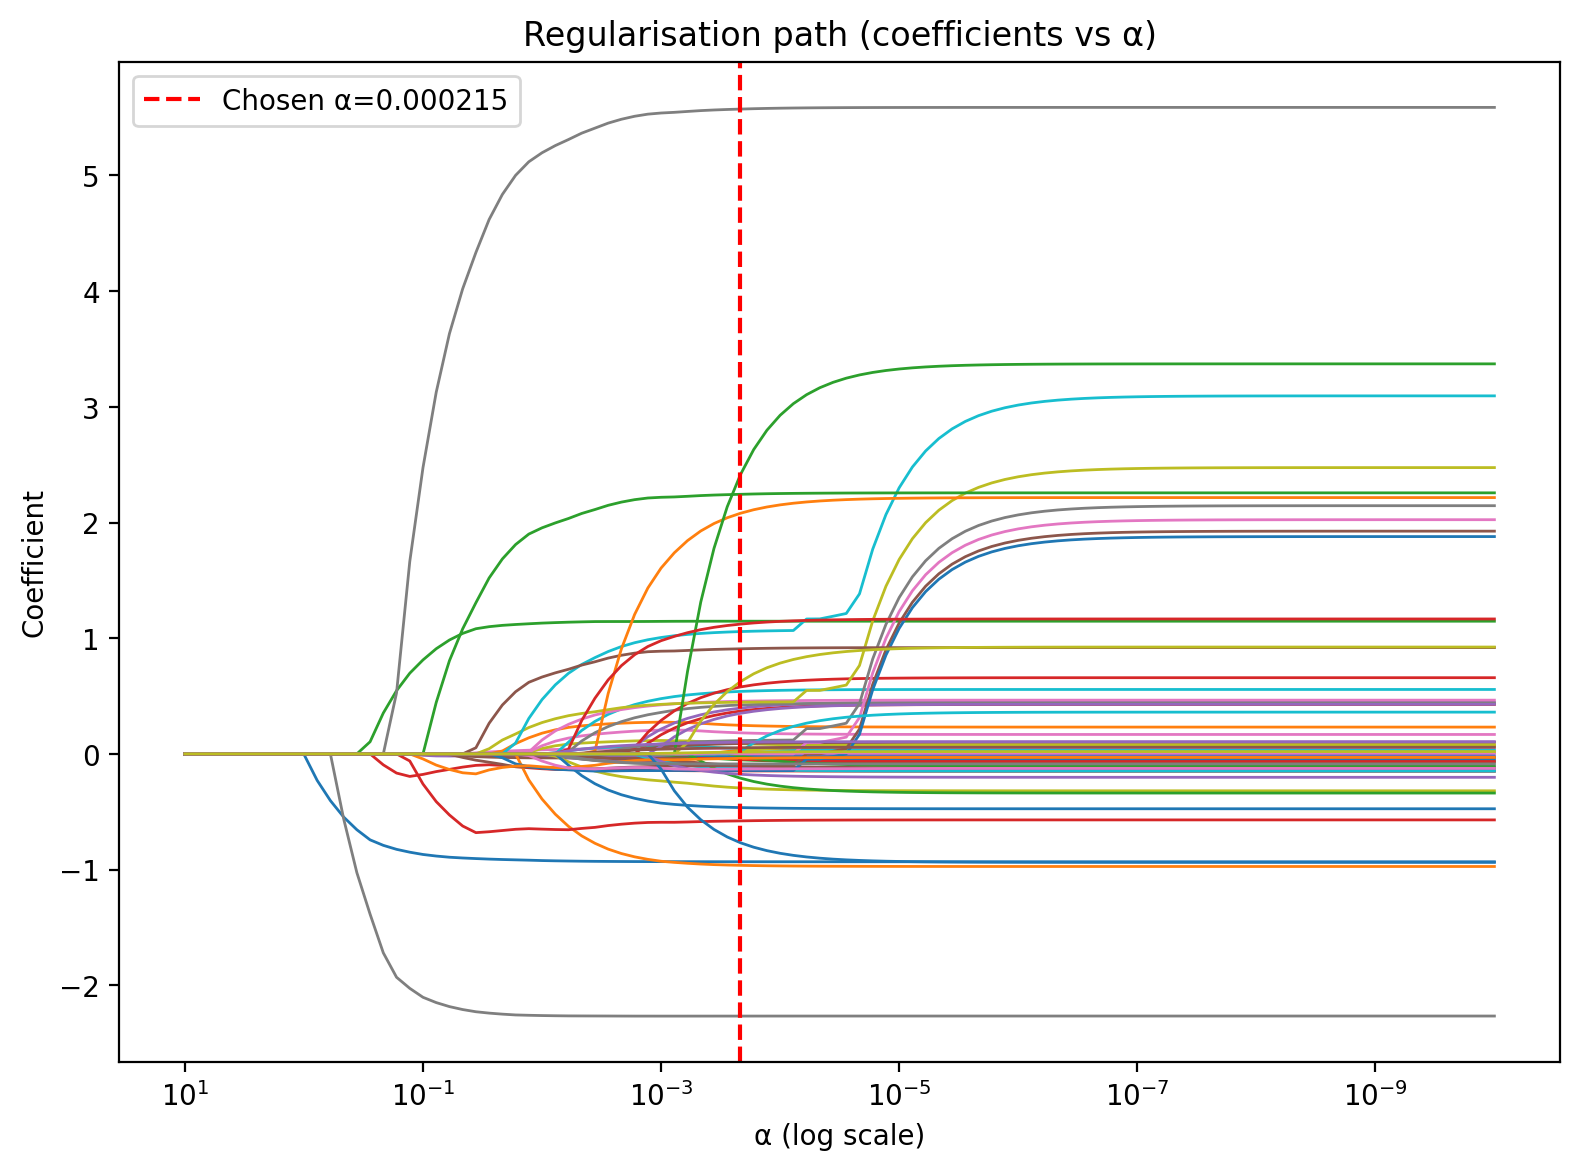

In [23]:
from sklearn.linear_model import lasso_path

X_centered = X_processed - X_processed.mean(axis=0)
Y_centered = Y_processed - Y_processed.mean()

# Use the exact same parameters as LassoCV for perfect matching
alphas_path, coefs_path, _ = lasso_path(
    X_centered, 
    Y_centered, 
    alphas=alphas,
    max_iter=lasso.max_iter,
    tol=lasso.tol,
    selection=lasso.selection
)

plt.figure(figsize=(8,6))
for k in range(coefs_path.shape[0]):  # each feature
    plt.plot(alphas_path,(coefs_path[k, :]), lw=1)

plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('α (log scale)')
plt.axvline(lasso.alpha_, ls='--', color='red', label=f'Chosen α={lasso.alpha_:.3g}')
plt.legend()
plt.ylabel('Coefficient')
plt.title('Regularisation path (coefficients vs α)')
plt.tight_layout()
plt.show()

At chosen alpha (α=0.000215), number of nonzero coefficients: 58


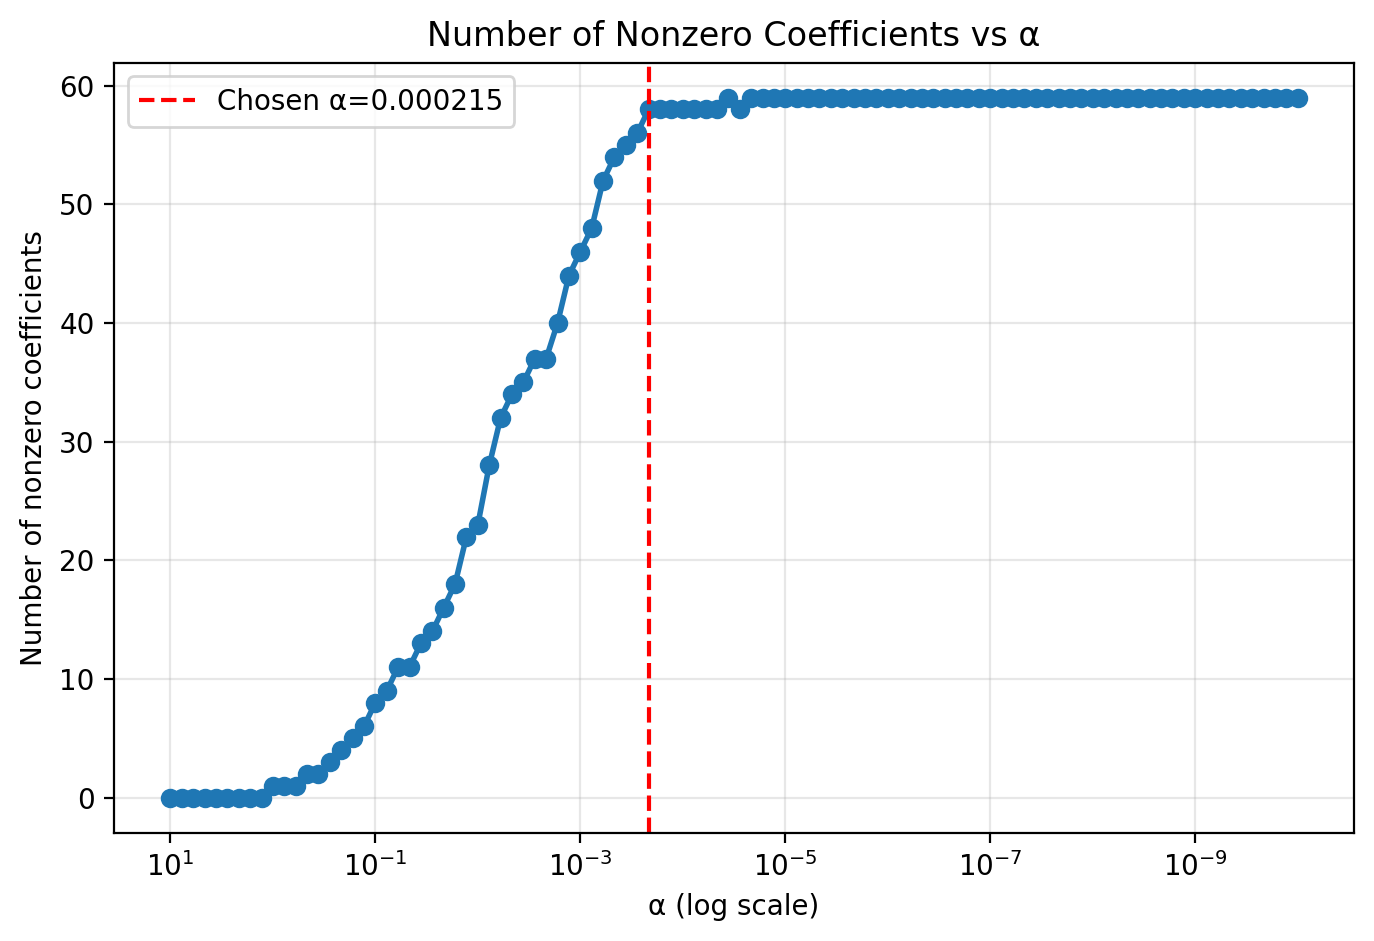

In [24]:
# Number of Nonzero Coefficients vs Alpha (Model Sparsity Path)

# Ensure coefs_perfect and alphas_perfect are defined using lasso_path with centered X and Y
from sklearn.linear_model import lasso_path

X_centered = X_processed - X_processed.mean(axis=0)
Y_centered = Y_processed - Y_processed.mean()

alphas_perfect, coefs_perfect, _ = lasso_path(
    X_centered,
    Y_centered,
    alphas=lasso.alphas_,
    max_iter=lasso.max_iter,
    tol=lasso.tol,
    selection=lasso.selection
)

num_nonzero = (coefs_perfect != 0).sum(axis=0)

plt.figure(figsize=(8,5))
plt.plot(alphas_perfect, num_nonzero, marker='o', lw=2)
plt.axvline(lasso.alpha_, ls='--', color='red', label=f'Chosen α={lasso.alpha_:.3g}')
plt.xscale('log')
plt.gca().invert_xaxis()  # standard LASSO plotting convention
plt.xlabel('α (log scale)')
plt.ylabel('Number of nonzero coefficients')
plt.title('Number of Nonzero Coefficients vs α')
plt.grid(True, alpha=0.3)
plt.legend()

print(f"At chosen alpha (α={lasso.alpha_:.3g}), number of nonzero coefficients: {np.sum(lasso.coef_ != 0)}")

Above, we can see that our LASSO model wants to include all but ONE of the predictors to minimize MSE. This suggests that most predictors have some explanatory power for GHQ score, and that multicollinearity is not a major issue in this dataset.